In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,

# THEN FEEL FREE TO DELETE THIS CELL.

# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON

# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR

# NOTEBOOK.



child_mind_institute_problematic_internet_use_path = '/kaggle/input/child-mind-institute-problematic-internet-use'


print('Data source import complete.')


Data source import complete.


**This notebook is focusing on HMS EDA**

In [2]:
palette='viridis'

# Import Libraries

In [3]:
!pip install hyperopt scikit-learn lightgbm xgboost catboost

In [4]:
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np

pd.set_option('display.max_columns', 500)

pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt

import seaborn as sns

from scipy.stats import zscore

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer



import scipy.cluster.hierarchy as sch

from sklearn.cluster import AgglomerativeClustering

from sklearn.impute import KNNImputer

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

from sklearn.preprocessing import StandardScaler

import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import cohen_kappa_score, make_scorer

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb

import xgboost as xgb

from catboost import CatBoostClassifier


# Helper Functions

In [5]:
def filter_by_instrument(df_train, df_dict, instrument_filter):

    """

    Filter the training dataset by a specific instrument using the dictionary file.



    Parameters:

        df_train (pd.DataFrame): The training dataset.

        df_dict (pd.DataFrame): The dictionary file.

        instrument_filter (str): Instrument name to filter columns.



    Returns:

        pd.DataFrame: Filtered training data for the specified instrument.

        pd.DataFrame: Filtered dictionary for the specified instrument.

    """

    df_dict_instrument = df_dict[df_dict['Instrument'] == instrument_filter]

    columns = df_dict_instrument['Field'].tolist()

    df_filtered = df_train[columns]

    return df_filtered, df_dict_instrument





def general_info(df, name="Dataset"):

    """

    Display general information about the dataset.



    Parameters:

        df (pd.DataFrame): The dataset to analyze.

        name (str): The name of the dataset for display purposes.

    """

    print(f"Summary of {name}:")

    print(df.info())

    print("\nSummary Statistics:")

    print(df.describe())

    print("\nMissing Values Percentage:")

    print(df.isnull().sum() / len(df))

    total_rows = df.shape[0]



    completely_missing_rows = df[df.isnull().all(axis=1)].shape[0]

    # Total missing values

    total_missing_values = df.isnull().sum().sum()

    percentage_completely_missing_rows = (completely_missing_rows / total_rows) * 100

    print("\n Totally Missing Rows Percentage:")

    print(f"{percentage_completely_missing_rows:.2f}")



def analyze_categorical(df, categorical_columns):

    """

    Analyze categorical columns by printing value counts.



    Parameters:

        df (pd.DataFrame): The dataset.

        categorical_columns (list): List of categorical column names.

    """

    for col in categorical_columns:

        print(f"\nValue Counts for {col}:")

        print(df[col].value_counts())



def analyze_numerical(df, numerical_columns):

    """

    Analyze numerical columns by generating descriptive statistics.



    Parameters:

        df (pd.DataFrame): The dataset.

        numerical_columns (list): List of numerical column names.

    """

    print("\nDescriptive Statistics for Numerical Columns:")

    print(df[numerical_columns].describe())



def plot_numerical_distributions(df, numerical_columns):

    """

    Plot distributions for numerical columns.



    Parameters:

        df (pd.DataFrame): The dataset.

        numerical_columns (list): List of numerical column names.

    """

    for col in numerical_columns:

        plt.figure(figsize=(8, 4))

        sns.histplot(df[col], kde=True, bins=30)

        plt.title(f'Distribution of {col}')

        plt.show()

def plot_categorical_distributions(df, categorical_columns):

    """

    Plot bar charts for categorical columns.



    Parameters:

        df (pd.DataFrame): The dataset.

        categorical_columns (list): List of categorical column names.

    """

    for col in categorical_columns:

        plt.figure(figsize=(8, 4))

        df[col].value_counts().plot(kind='bar', color='skyblue')

        plt.title(f'Distribution of {col}')

        plt.ylabel('Count')

        plt.xlabel('Categories')

        plt.xticks(rotation=45)

        plt.show()

# Define Directories

In [6]:
root_path = child_mind_institute_problematic_internet_use_path

csv_train_path = f'{root_path}/train.csv'

csv_dict_path = f'{root_path}/data_dictionary.csv'



csv_test_path = f'{root_path}/test.csv'

# Load CSV Data

In [7]:
df_train_csv = pd.read_csv(csv_train_path)

df_test_csv = pd.read_csv(csv_test_path)

df_dict_csv = pd.read_csv(csv_dict_path)

unique_instruments = np.unique(df_dict_csv['Instrument'])

print(f"Unique Instruments are\n  {unique_instruments}")

print(f"The number of Unique Instruments is  {len(unique_instruments)}")

Unique Instruments are
  ['Bio-electric Impedance Analysis' "Children's Global Assessment Scale"
 'Demographics' 'FitnessGram Child' 'FitnessGram Vitals and Treadmill'
 'Identifier' 'Internet Use' 'Parent-Child Internet Addiction Test'
 'Physical Activity Questionnaire (Adolescents)'
 'Physical Activity Questionnaire (Children)' 'Physical Measures'
 'Sleep Disturbance Scale']
The number of Unique Instruments is  12


In [8]:
df_train_csv.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [9]:
train_csv_columns = df_train_csv.columns

test_csv_columns = df_test_csv.columns

In [10]:
print("Number of training columns is: ", len(train_csv_columns))

print("Number of test columns is: ", len(test_csv_columns))

Number of training columns is:  82
Number of test columns is:  59


In [11]:
# different columns

diff_cols = set(train_csv_columns) - set(test_csv_columns)

diff_cols

diff_cols.remove('sii')

In [12]:
# List of PCIAT columns

PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]



df_train_csv['Calculated_PCIAT_Total'] = df_train_csv[PCIAT_cols].sum(axis=1)

# convert 0 to NaN

df_train_csv['Calculated_PCIAT_Total'] = df_train_csv['Calculated_PCIAT_Total'].replace(0, np.nan)

df_train_csv['Calculated_PCIAT_Total'] = df_train_csv['Calculated_PCIAT_Total'].replace(0.0, np.nan)

df_train_csv['PCIAT-PCIAT_Total'] = df_train_csv['PCIAT-PCIAT_Total'].replace(0.0, np.nan)



# Count mismatched totals

miscalculated_PCIAT_Total = (df_train_csv['PCIAT-PCIAT_Total'] != df_train_csv['Calculated_PCIAT_Total'])



PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]



def recalculate_sii(row):

    if pd.isna(row['PCIAT-PCIAT_Total']):

        return np.nan

    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5

    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:

        return 0

    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:

        return 1

    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:

        return 2

    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:

        return 3

    return np.nan

df_train_csv['Severity Impairment Index (SII)'] = df_train_csv.apply(recalculate_sii, axis=1)


In [13]:


# Define the mapping using pd.cut

bins = [5 ,14, 22]

labels = ['Child', 'Teen']



df_train_csv['Age Group'] = pd.cut(df_train_csv['Basic_Demos-Age'], bins=bins, labels=labels, right=True, include_lowest=True)

df_test_csv['Age Group'] = pd.cut(df_test_csv['Basic_Demos-Age'], bins=bins, labels=labels, right=True, include_lowest=True)


# Fixing Labels

We have a lot of missing values in the target

In [14]:
pciat_columns = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]

In [15]:
# List of PCIAT columns

question_columns = pciat_columns

# Multiply relevant columns by 5 and calculate the sum across the row

df_train_csv['Calculated_PCIAT_Total'] = df_train_csv[question_columns].sum(axis=1)

# convert 0 to NaN

df_train_csv['Calculated_PCIAT_Total'] = df_train_csv['Calculated_PCIAT_Total'].replace(0, np.nan)

df_train_csv['Calculated_PCIAT_Total'] = df_train_csv['Calculated_PCIAT_Total'].replace(0.0, np.nan)

df_train_csv['PCIAT-PCIAT_Total'] = df_train_csv['PCIAT-PCIAT_Total'].replace(0.0, np.nan)



# Count mismatched totals

miscalculated_PCIAT_Total = (df_train_csv['PCIAT-PCIAT_Total'] != df_train_csv['Calculated_PCIAT_Total']).sum()

print(f"Number of Miscalculated PCIAT Totals: {miscalculated_PCIAT_Total}")




Number of Miscalculated PCIAT Totals: 1537


In [16]:
differences = df_train_csv[

    ~((df_train_csv['Calculated_PCIAT_Total'] == df_train_csv['PCIAT-PCIAT_Total']) |

      (df_train_csv['Calculated_PCIAT_Total'].isna() & df_train_csv['PCIAT-PCIAT_Total'].isna()))

]

(differences[['PCIAT-PCIAT_Total', 'Calculated_PCIAT_Total']])


,PCIAT-PCIAT_Total,Calculated_PCIAT_Total


In [17]:
df_train_csv.iloc[1,:]

df_train_csv[(df_train_csv['sii']==0.0) & (df_train_csv['Severity Impairment Index (SII)'].isna()) ]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Calculated_PCIAT_Total,Severity Impairment Index (SII),Age Group
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.970850,1.0,21.0352,14.9740,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.34,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Fall,46.0,64.0,Summer,0.0,0.0,NaN,NaN,Child
16,00d56d4b,Spring,5,1,Summer,80.0,Spring,17.284504,44.0,47.6,NaN,61.0,76.0,109.0,Spring,NaN,NaN,NaN,Spring,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,10.5,1.0,10.0,1.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Spring,37.0,53.0,Spring,0.0,0.0,NaN,NaN,Child
24,011e71c3,Summer,15,0,Fall,70.0,Summer,21.177784,62.0,115.8,NaN,61.0,58.0,144.0,NaN,NaN,NaN,NaN,Summer,0.0,0.0,21.4,1.0,20.9,1.0,5.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,Fall,4.0,8.72618,21.1801,1289.740,2708.46,20.57170,79.6375,14.5659,6.614210,36.162500,2.0,35.9062,23.1596,70.9113,35.1487,56.4779,Summer,3.53,NaN,NaN,Summer,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,NaN,2.0,30.0,Summer,34.0,49.0,Summer,1.0,0.0,30.0,NaN,Teen
26,012e3869,Summer,6,0,Winter,60.0,Summer,NaN,NaN,NaN,NaN,73.0,86.0,110.0,NaN,NaN,NaN,NaN,Summer,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,9.5,1.0,9.5,1.0,6.0,1.0,Fall,2.0,2.78600,25.2668,1027.230,1643.57,11.05050,51.6765,15.7693,9.497480,31.123500,2.0,26.7417,13.8843,48.8905,21.1339,37.7922,NaN,NaN,NaN,NaN,Summer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Summer,0.0,0.0,NaN,NaN,Child
36,02073150,Winter,7,0,Spring,65.0,Winter,17.603120,50.0,62.6,NaN,54.0,92.0,90.0,Winter,5.0,5.0,21.0,Winter,4.0,1.0,NaN,NaN,NaN,NaN,8.0,1.0,7.5,1.0,8.0,1.0,6.0,1.0,Spring,5.0,5.91061,17.6050,1006.070,2414.57,10.36920,49.4226,13.8991,3.705900,13.177400,2.0,26.7413,12.3120,43.5120,23.8351,37.1105,NaN,NaN,NaN,NaN,Spring,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Winter,39.0,55.0,Winter,0.0,0.0,NaN,NaN,Child
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3925,fd0d9bca,Fall,8,1,Spring,80.0,Winter,12.635281,52.0,48.6,NaN,59.0,85.0,118.0,Winter,7.0,10.0,59.0,Winter,13.0,1.0,NaN,NaN,NaN,NaN,7.0,1.0,10.0,1.0,

# DATA LEAKAGE

In [18]:
diff_cols

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season'}

In [19]:
df_dict_csv = pd.read_csv(csv_dict_path)

unique_instruments = np.unique(df_dict_csv['Instrument'])

print(f"Unique Instruments are\n  {unique_instruments}")

print(f"The number of Unique Instruments is  {len(unique_instruments)}")

Unique Instruments are
  ['Bio-electric Impedance Analysis' "Children's Global Assessment Scale"
 'Demographics' 'FitnessGram Child' 'FitnessGram Vitals and Treadmill'
 'Identifier' 'Internet Use' 'Parent-Child Internet Addiction Test'
 'Physical Activity Questionnaire (Adolescents)'
 'Physical Activity Questionnaire (Children)' 'Physical Measures'
 'Sleep Disturbance Scale']
The number of Unique Instruments is  12


We dropped all PCAIT (Parent-Child Internet Addiction Test)



So, we must drop the column from dictonary and all its rows

In [20]:
df_dict_csv = df_dict_csv[df_dict_csv['Instrument'] != 'Parent-Child Internet Addiction Test']

unique_instruments = np.unique(df_dict_csv['Instrument'])

print(f"Unique Instruments are\n  {unique_instruments}")

print(f"The number of Unique Instruments is  {len(unique_instruments)}")

Unique Instruments are
  ['Bio-electric Impedance Analysis' "Children's Global Assessment Scale"
 'Demographics' 'FitnessGram Child' 'FitnessGram Vitals and Treadmill'
 'Identifier' 'Internet Use'
 'Physical Activity Questionnaire (Adolescents)'
 'Physical Activity Questionnaire (Children)' 'Physical Measures'
 'Sleep Disturbance Scale']
The number of Unique Instruments is  11


In [21]:
df_train_csv.drop(columns=diff_cols, inplace=True)

In [22]:
df_train_csv.drop(columns = ['sii', 'Calculated_PCIAT_Total'], inplace=True)

# Show High Correlations

In [23]:
# Calculate the correlation matrix for float columns

correlation_matrix = df_train_csv.select_dtypes(include='float').corr()



# Style the correlation matrix to highlight values greater than 0.9

styled_corr_matrix = correlation_matrix.style.applymap(

    lambda x: 'background-color: yellow' if abs(x) > 0.95 and x != 1 else ''

)



# Display the styled correlation matrix

styled_corr_matrix

/tmp/ipykernel_23/197030251.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_corr_matrix = correlation_matrix.style.applymap(


,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Severity Impairment Index (SII)
CGAS-CGAS_Score,1.000000,-0.094074,-0.023185,-0.076399,-0.076116,-0.005292,-0.010108,-0.021392,0.154628,0.180734,-0.044353,0.157575,0.169200,-0.010903,0.004992,-0.009042,0.004714,0.107293,0.101005,0.028771,-0.007134,0.026727,0.005806,0.079537,0.060672,0.095811,-0.032322,-0.085013,-0.037491,-0.031408,-0.035280,-0.037491,-0.034399,-0.031610,0.025001,-0.066803,-0.041182,-0.036704,-0.041387,-0.039307,-0.037886,0.065593,0.000009,-0.145369,-0.148457,-0.021596,-0.098546
Physical-BMI,-0.094074,1.000000,0.487097,0.865662,0.892149,0.141795,-0.036955,0.312045,-0.136656,-0.162676,-0.039083,0.114264,-0.174540,0.288864,0.173366,0.302914,0.181172,-0.007892,-0.129541,-0.070431,-0.104028,-0.062557,-0.095135,0.137997,-0.036782,-0.079855,-0.002360,0.968849,0.086477,0.085351,0.092762,0.086477,0.320813,0.489222,0.101775,0.616253,0.113819,0.057626,0.160784,0.115083,0.102044,-0.159905,-0.044409,0.087655,0.086185,0.296709,0.200620
Physical-Height,-0.023185,0.487097,1.000000,0.833844,0.688033,0.115724,-0.217080,0.299157,0.057259,0.071940,-0.105032,0.505183,-0.066759,0.542173,0.109289,0.592608,0.170721,0.330608,0.040996,-0.134765,-0.197362,-0.143851,-0.205027,0.270351,-0.067210,0.135236,0.001867,0.512674,0.116670,0.144326,0.119628,0.116670,0.212631,0.219920,0.064058,0.458972,0.147519,0.088345,0.212615,0.146559,0.131918,0.117957,-0.014736,0.036687,0.036478,0.399367,0.337529
Physical-Weight,-0.076399,0.865662,0.833844,1.000000,0.916710,0.145480,-0.134071,0.355700,-0.077202,-0.089170,-0.083852,0.346548,-0.141485,0.474052,0.170177,0.511650,0.203847,0.178322,-0.059256,-0.110027,-0.160812,-0.110269,-0.159932,0.220819,-0.056241,0.018653,-0.001207,0.858036,0.117096,0.131515,0.121697,0.117096,0.318942,0.401660,0.097324,0.600885,0.151615,0.084113,0.216015,0.151983,0.134872,-0.066295,-0.049310,0.075098,0.073482,0.375851,0.295320
Physical-Waist_Circumference,-0.076116,0.892149,0.688033,0.916710,1.000000,0.195975,-0.090119,0.388621,nan,nan,nan,0.177024,-0.179970,0.277030,0.056531,0.250208,0.044520,0.048906,-0.102328,-0.162192,-0.183261,-0.179390,-0.208776,0.160563,-0.028484,0.052011,0.744749,0.920539,0.830669,0.603203,0.818122,0.830669,0.809447,0.861946,0.915948,0.716520,0.794825,0.796639,0.833994,0.785021,0.824784,-0.162890,-0.180092,0.089831,0.091152,0.371418,0.249150
Physical-Diastolic_BP,-0.005292,0.141795,0.115724,0.145480,0.195975,1.000000,0.148024,0.657705,-0.003465,0.012069,-0.003196,0.012820,-0.001916,0.051283,0.006125,0.052337,0.019938,-0.033701,-0.063331,-0.013072,-0.040133,-0.006719,-0.026258,-0.012714,-0.048912,0.004244,0.009558,0.147462,0.024388,0.026293,0.024652,0.024388,0.035814,0.084176,0.004986,0.127627,0.026862,0.022023,0.036645,0.029996,0.025646,-0.128304,-0.037674,0.006702,0.008502,0.074258,0.035481
Physical-HeartRate,-0.010108,-0.036955,-0.217080,-0.134071,-0.090119,0.148024,1.000000,0.122261,-0.178429,-0.186820,0.016141,-0.144101,0.014147,-0.064253,-0.018551,-0.099775,-0.081917,-0.159332,-0.087847,0.015569,0.043470,0.014471,0.043870,-0.105770,-0.017293,-0.099425,0.020872,-0.019838,-0.004467,-0.019740,-0.003722,-0.004467,-0.050742,0.030611,-0.023012,0.006862,-0.013836,0.002280,-0.026013,-0.014773,-0.008125,-0.287037,-0.163317,0.049194,0.047932,-0.073453,-0.024856
Physi

# Describe: Bio-electric Impedance Analysis

Here, I will perform Exploratory Data Analysis and Handle any missing values or outliers

In [24]:
# Apply Filters

instrument_filter = "Bio-electric Impedance Analysis"

df_bia, df_dict_bia = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_bia.head()

,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW
0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909
1,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_dict_bia

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


In [26]:
# General information

general_info(df_bia, name="Bio-electric Impedance Analysis")

Summary of Bio-electric Impedance Analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BIA-Season                  2145 non-null   object 
 1   BIA-BIA_Activity_Level_num  1991 non-null   float64
 2   BIA-BIA_BMC                 1991 non-null   float64
 3   BIA-BIA_BMI                 1991 non-null   float64
 4   BIA-BIA_BMR                 1991 non-null   float64
 5   BIA-BIA_DEE                 1991 non-null   float64
 6   BIA-BIA_ECW                 1991 non-null   float64
 7   BIA-BIA_FFM                 1991 non-null   float64
 8   BIA-BIA_FFMI                1991 non-null   float64
 9   BIA-BIA_FMI                 1991 non-null   float64
 10  BIA-BIA_Fat                 1991 non-null   float64
 11  BIA-BIA_Frame_num           1991 non-null   float64
 12  BIA-BIA_ICW                 1991 non-null   fl

In [27]:
# Classify variables based on type

qualitative_nominal_bia = ['BIA-Season']

qualitative_ordinal_bia = ['BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num']

quantitative_ratio_bia = [

    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',

    'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW',

    'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'

]

quantitative_interval_bia = []


Value Counts for BIA-Season:
BIA-Season
Summer    669
Fall      567
Spring    513
Winter    396
Name: count, dtype: int64

Value Counts for BIA-BIA_Activity_Level_num:
BIA-BIA_Activity_Level_num
3.0    698
2.0    637
4.0    305
1.0    266
5.0     85
Name: count, dtype: int64

Value Counts for BIA-BIA_Frame_num:
BIA-BIA_Frame_num
2.0    940
1.0    779
3.0    272
Name: count, dtype: int64


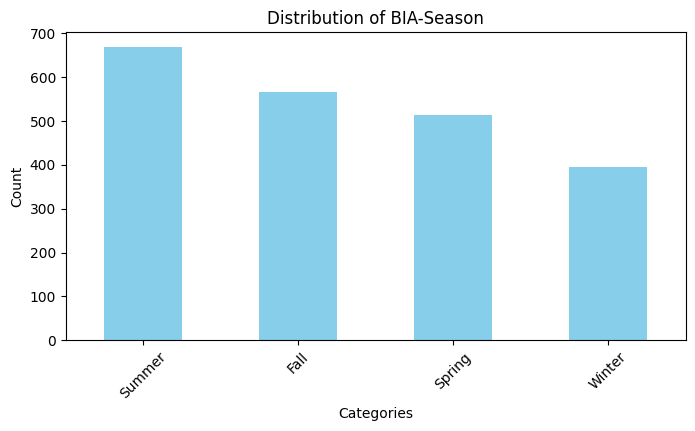

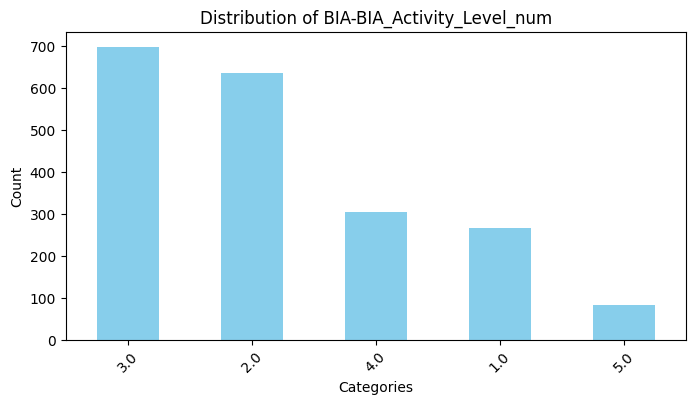

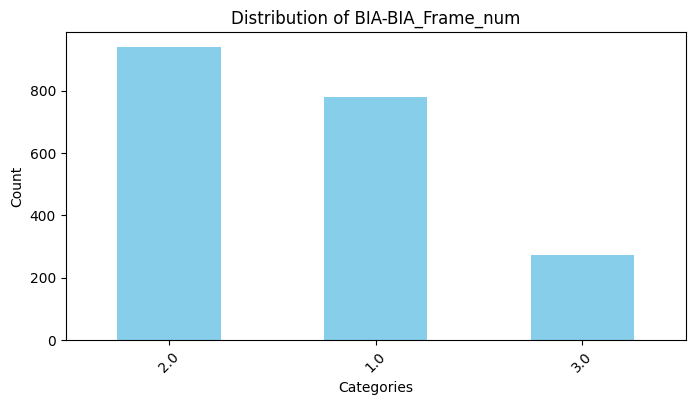

In [28]:
# Analyze categorical columns

categorical_columns_bia = qualitative_nominal_bia + qualitative_ordinal_bia

analyze_categorical(df_bia, categorical_columns_bia)

plot_categorical_distributions(df_bia, categorical_columns_bia)


Descriptive Statistics for Numerical Columns:
       BIA-BIA_BMC  BIA-BIA_BMI   BIA-BIA_BMR    BIA-BIA_DEE  BIA-BIA_ECW  \
count  1991.000000  1991.000000   1991.000000    1991.000000  1991.000000   
mean      6.719826    19.367048   1237.018187    2064.693747    20.825346   
std      92.586325     5.047848   1872.383246    2836.246272    73.266287   
min      -7.789610     0.048267    813.397000    1073.450000     1.789450   
25%       2.966905    15.913600   1004.710000    1605.785000    11.109550   
50%       3.922720    17.966500   1115.380000    1863.980000    15.928000   
75%       5.460925    21.461100   1310.360000    2218.145000    25.162200   
max    4115.360000    53.924300  83152.200000  124728.000000  3233.000000   

       BIA-BIA_FFM  BIA-BIA_FFMI  BIA-BIA_FMI  BIA-BIA_Fat  BIA-BIA_ICW  \
count  1991.000000   1991.000000  1991.000000  1991.000000  1991.000000   
mean     74.021708     15.030554     4.336495    16.855020    33.173380   
std     199.433753      5.792505  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


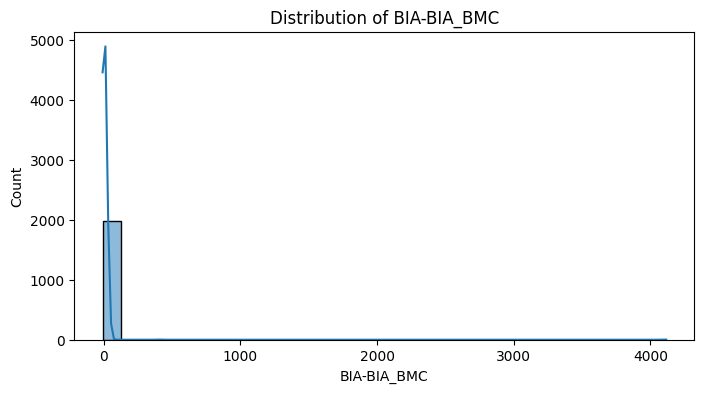

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


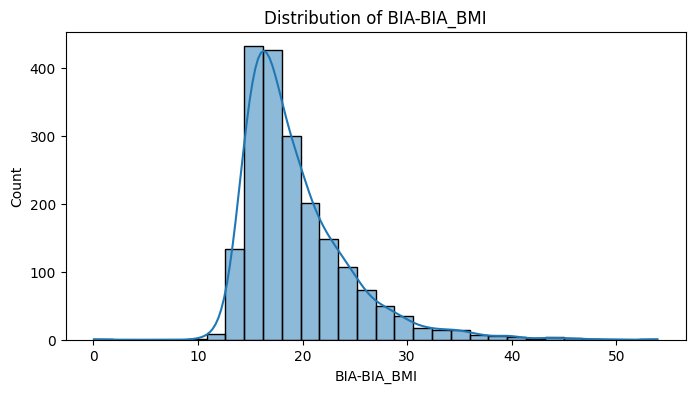

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


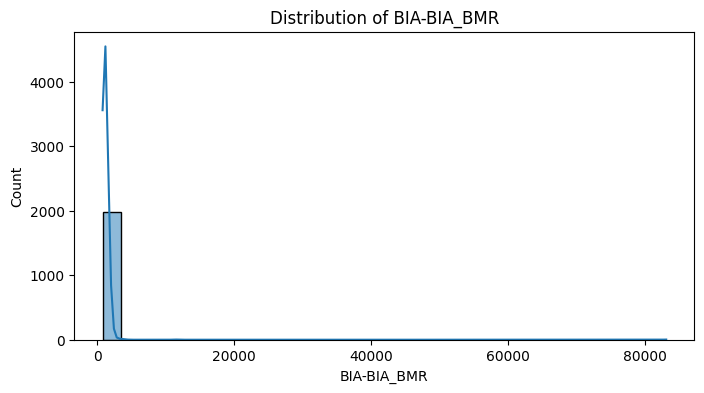

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


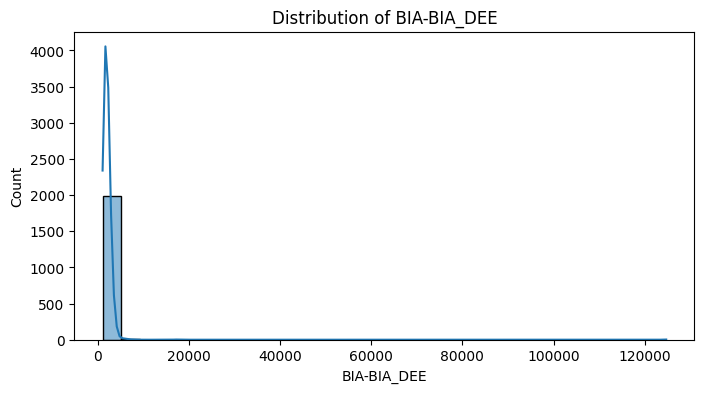

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


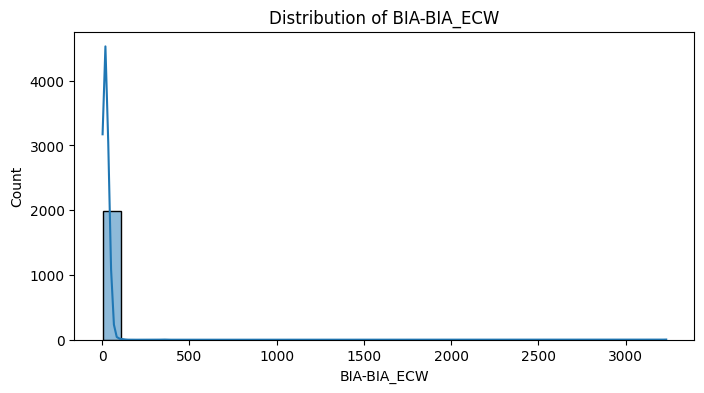

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


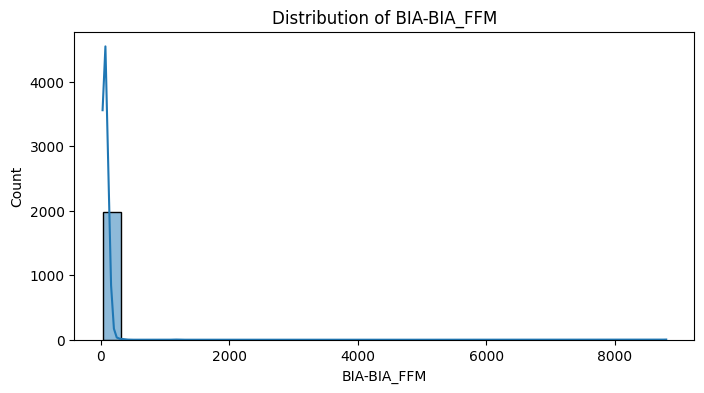

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


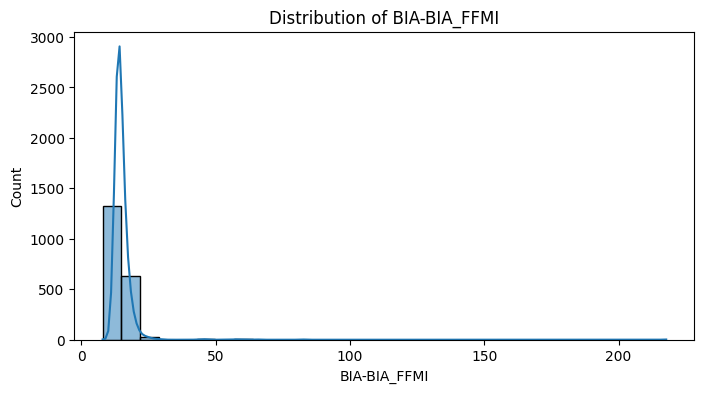

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


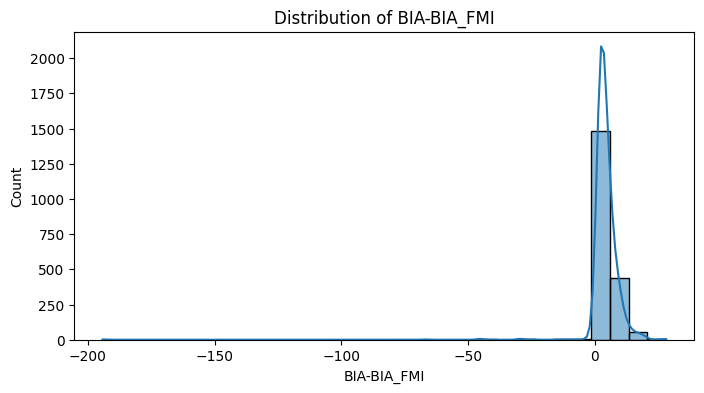

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


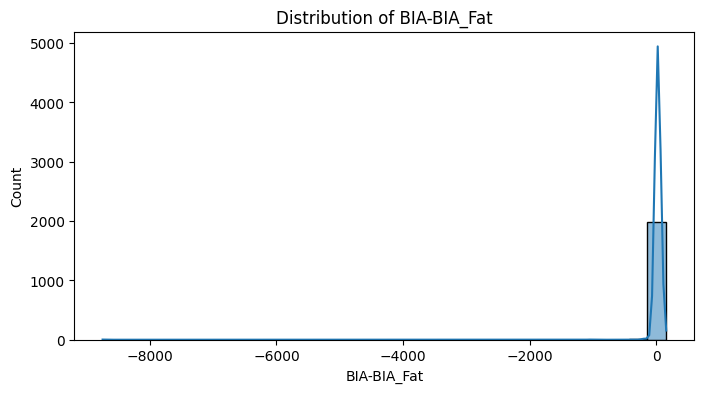

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


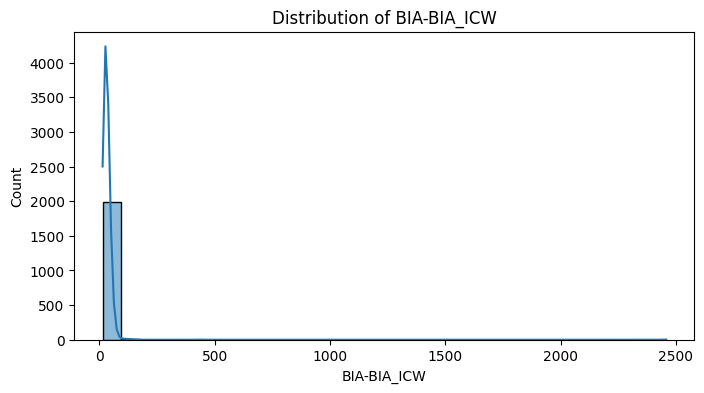

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


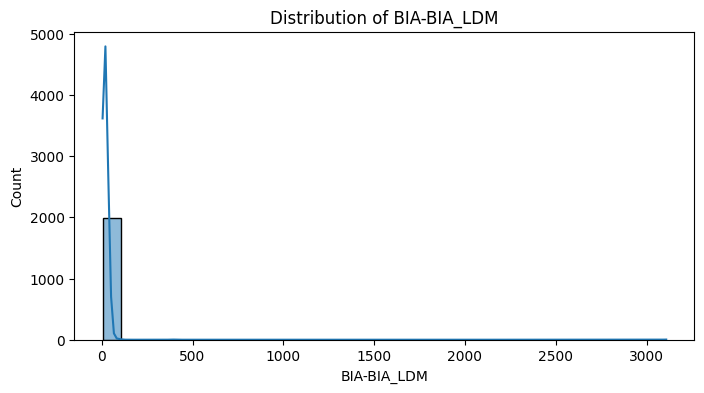

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


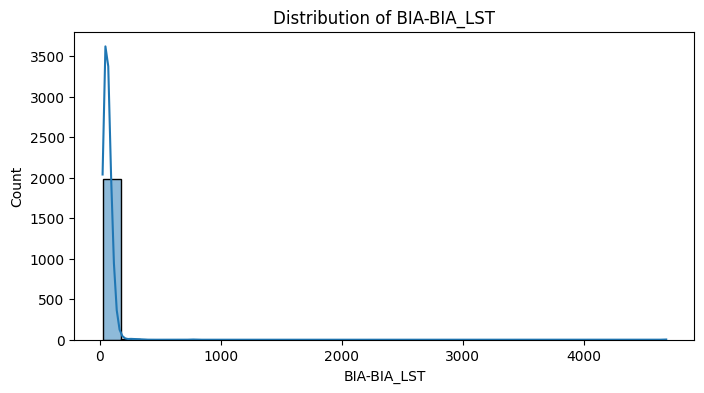

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


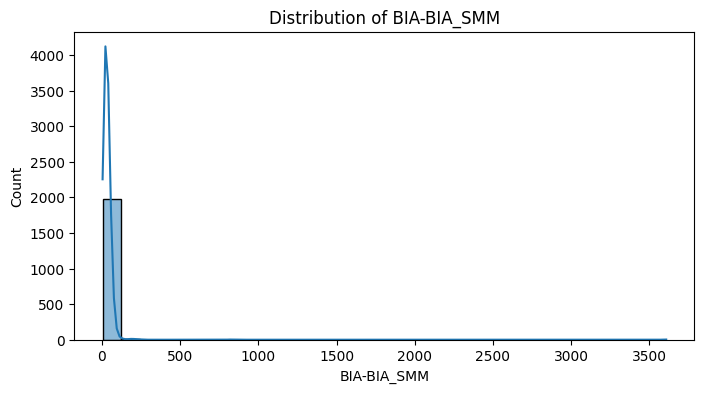

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


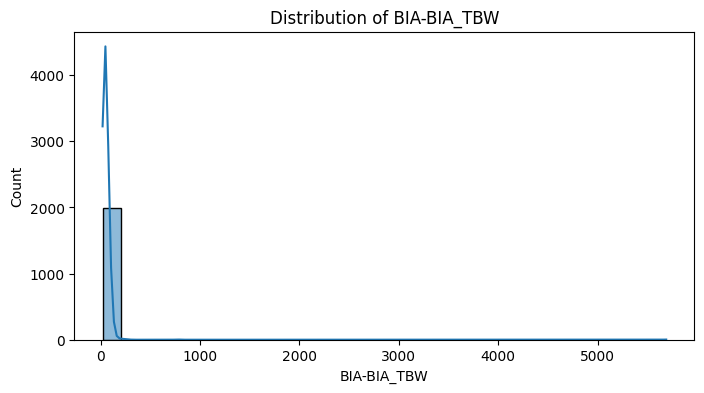

In [29]:
#### Analyze Numerical columns



numerical_columns_bia = quantitative_ratio_bia + quantitative_interval_bia

analyze_numerical(df_bia, numerical_columns_bia)

plot_numerical_distributions(df_bia, numerical_columns_bia)

#### Insights

We have two features that have almost 100% correlation. it is basically the same feature!

In [30]:
# show columns that have 2% or more difference

bmi_diff = df_train_csv['BIA-BIA_BMI'] - df_train_csv['Physical-BMI']

# round the difference

sum(round(bmi_diff.dropna(), 2))

12.630000000000008

## Calculate BMI using Physical Weight and Height

In [31]:


# --- 1. Calculating BMI ---



df_train_csv['Calculated-BMI'] = 703 * df_train_csv['Physical-Weight'].dropna() / (df_train_csv['Physical-Height'].dropna() ** 2)



df_test_csv['Calculated-BMI'] = 703 * df_test_csv['Physical-Weight'].dropna() / (df_test_csv['Physical-Height'].dropna() ** 2)


## Visuals

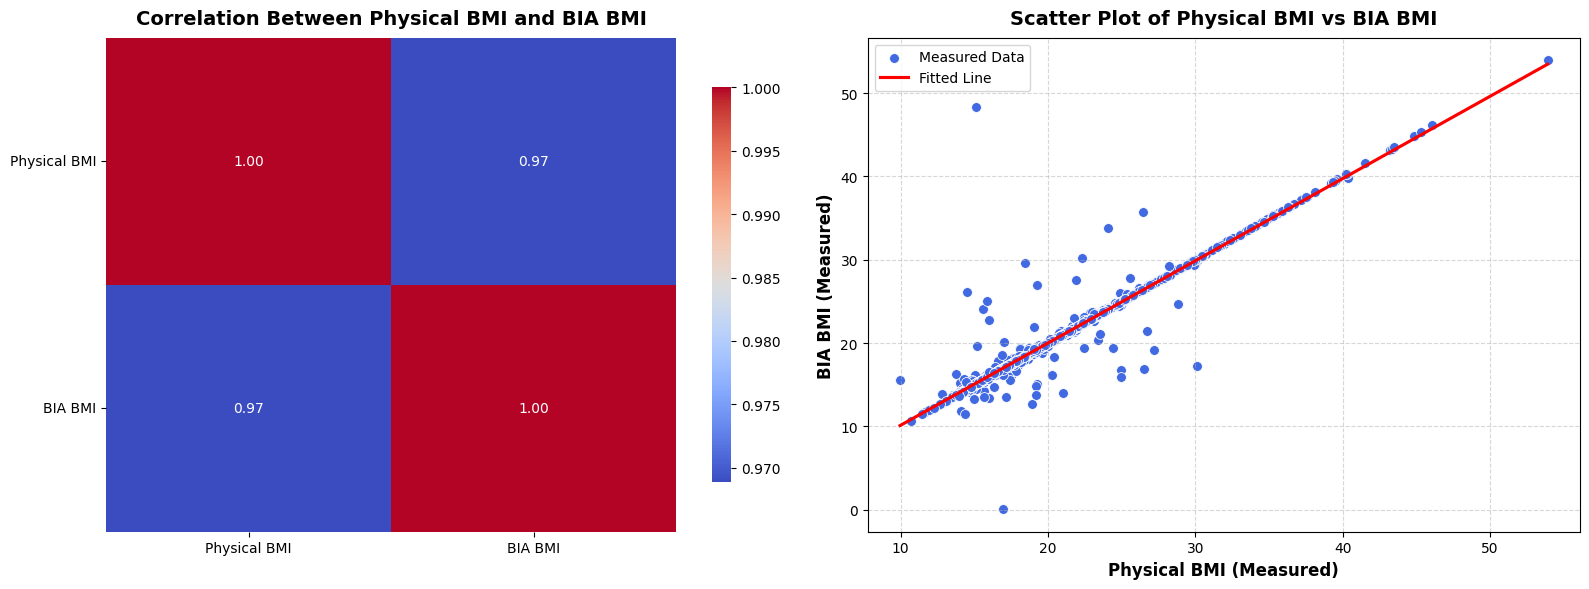

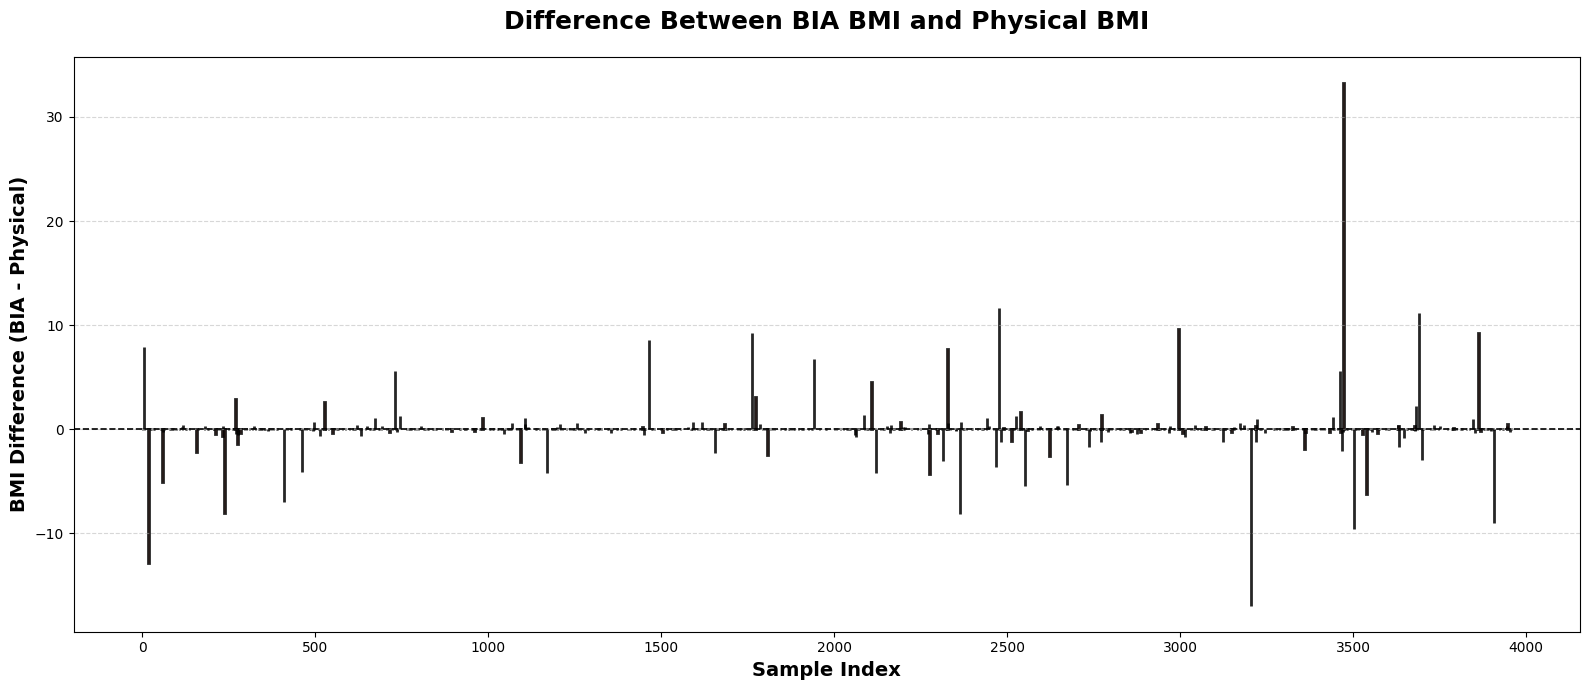

In [32]:


# --- 2. Calculate Correlation ---

bmi_diff = df_train_csv['BIA-BIA_BMI'] - df_train_csv['Physical-BMI']

corr = df_train_csv[['Physical-BMI', 'BIA-BIA_BMI']].corr()



# --- 3. Combined Plot ---

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1x2 grid layout



# --- Heatmap (Left) ---

sns.heatmap(

    corr, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'shrink': 0.8}, ax=axes[0]

)

axes[0].set_title('Correlation Between Physical BMI and BIA BMI', fontsize=14, fontweight='bold', pad=10)

axes[0].set_xticklabels(['Physical BMI', 'BIA BMI'], fontsize=10)

axes[0].set_yticklabels(['Physical BMI', 'BIA BMI'], fontsize=10, rotation=0)



# --- Scatter Plot with Regression Line (Right) ---

sns.scatterplot(

    data=df_train_csv, x='Physical-BMI', y='BIA-BIA_BMI', color='royalblue', s=50, ax=axes[1], label='Measured Data'

)

sns.regplot(

    data=df_train_csv, x='Physical-BMI', y='BIA-BIA_BMI', scatter=False, color='red', ci=None, ax=axes[1], label= 'Fitted Line'

)

axes[1].set_title('Scatter Plot of Physical BMI vs BIA BMI', fontsize=14, fontweight='bold', pad=10)

axes[1].set_xlabel('Physical BMI (Measured)', fontsize=12, fontweight='bold')

axes[1].set_ylabel('BIA BMI (Measured)', fontsize=12, fontweight='bold')

axes[1].legend(loc='upper left', fontsize=10)

axes[1].grid(True, linestyle='--', alpha=0.5)



# --- Adjust Layout ---

plt.tight_layout()



# --- Save as PDF ---

plt.savefig("BMI_Correlation_and_ScatterPlot.pdf", dpi=600, bbox_inches='tight')



# Show the combined plot

plt.show()



# --- Enhanced BMI Difference Bar Plot ---

plt.figure(figsize=(16, 7))  # Larger figure size for better clarity



# Create bar plot with reduced width and visible edges

plt.bar(

    df_train_csv.index, bmi_diff,

    width=0.8,  # Narrower bars for spacing

    color='tomato',  # Solid, visible color

    alpha=0.85,  # Slight transparency

    edgecolor='black',  # Add black edges for clarity

    linewidth=2

)



# Add a horizontal reference line at 0

plt.axhline(0, color='black', linestyle='--', linewidth=1.2)



# Add gridlines for better readability

plt.grid(axis='y', linestyle='--', alpha=0.5)







# Add titles and labels

plt.title('Difference Between BIA BMI and Physical BMI', fontsize=18, fontweight='bold', pad=20)

plt.xlabel('Sample Index', fontsize=14, fontweight='bold')

plt.ylabel('BMI Difference (BIA - Physical)', fontsize=14, fontweight='bold')



# Adjust layout for clean display

plt.tight_layout()



# Show the plot

plt.show()


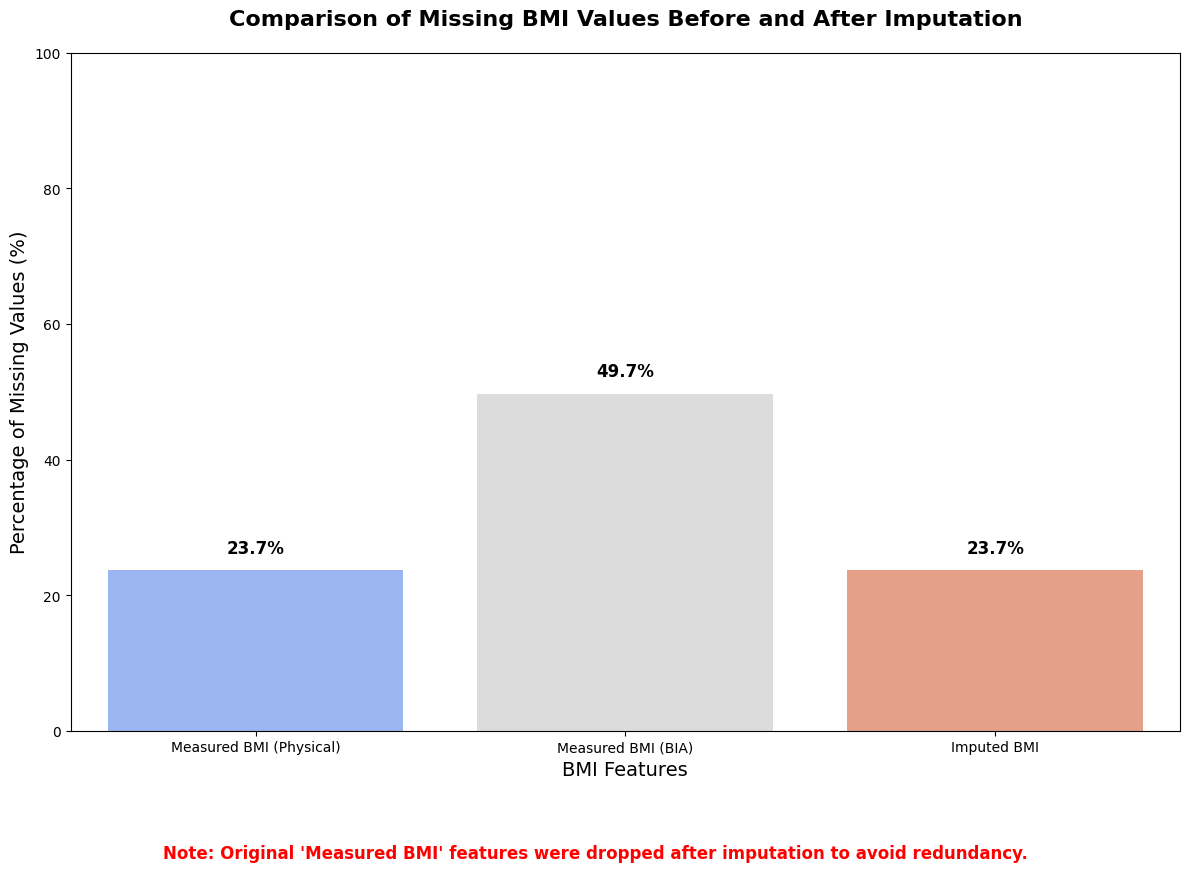

In [33]:
# Rename columns for clarity in the poster

renamed_features = {

    'Physical-BMI': 'Measured BMI (Physical)',

    'BIA-BIA_BMI': 'Measured BMI (BIA)',

    'Calculated-BMI': 'Imputed BMI'

}



# Calculate missing values

missing_physical_before = df_train_csv[['Physical-BMI']].isna().sum()

missing_bia_before = df_train_csv[['BIA-BIA_BMI']].isna().sum()

missing_after = df_train_csv[['Calculated-BMI']].isna().sum()

total_values = len(df_train_csv)



# Create a DataFrame summarizing missing values

missing_summary = pd.DataFrame({

    'Feature': [renamed_features['Physical-BMI'], renamed_features['BIA-BIA_BMI'], renamed_features['Calculated-BMI']],

    'Missing Values': [missing_physical_before['Physical-BMI'],

                       missing_bia_before['BIA-BIA_BMI'],

                       missing_after['Calculated-BMI']],

    'Percentage Missing': [missing_physical_before['Physical-BMI'] / total_values * 100,

                           missing_bia_before['BIA-BIA_BMI'] / total_values * 100,

                           missing_after['Calculated-BMI'] / total_values * 100]

})



# Create the bar plot

plt.figure(figsize=(12, 8))

sns.barplot(data=missing_summary, x='Feature', y='Percentage Missing', palette='coolwarm')



# Title and labels for poster readability

plt.title('Comparison of Missing BMI Values Before and After Imputation', fontsize=16, fontweight='bold', pad=20)

plt.ylabel('Percentage of Missing Values (%)', fontsize=14)

plt.xlabel('BMI Features', fontsize=14)



# Set Y-axis limits

plt.ylim(0, 100)



# Annotate each bar with percentage values

for i, row in missing_summary.iterrows():

    plt.text(i, row['Percentage Missing'] + 2, f"{row['Percentage Missing']:.1f}%",

             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')



# Add a professional note at the bottom

plt.figtext(0.5, -0.08,

            "Note: Original 'Measured BMI' features were dropped after imputation to avoid redundancy.",

            ha='center', fontsize=12, color='red', fontweight='bold')



# Clean up the layout

plt.tight_layout()

# save as pdf

plt.savefig('bmi_comparison.pdf', dpi=600, bbox_inches='tight')

plt.show()


## Drop both BMI features and engineer our own

In [34]:
df_train_csv.drop(columns=['Physical-BMI', 'BIA-BIA_BMI'], inplace=True)

df_test_csv.drop(columns=['Physical-BMI', 'BIA-BIA_BMI'], inplace=True)

# ss

#### **Insights for Bio-Electric Impedance Analysis (BIA) Data**




**General Observations**

- **Dataset Size:** The dataset contains 3,960 entries and 17 fields.

- **Data Types:**

  - 16 numerical fields (`float64`) primarily measuring physical metrics.

  - 1 categorical field (`BIA-Season`), indicating the season of participation.

- **Missing Data:**

  - The categorical field `BIA-Season` has 45.83% missing values.

  - All numerical fields have approximately 49.72% missing values.




**Key Insights**

1. **Missing Values:**

   - Nearly half of the dataset has missing data across all numerical fields. This suggests significant data quality issues that will need to be addressed through imputation or feature elimination.

   - The categorical field `BIA-Season` has slightly fewer missing values compared to the numerical fields, but it still represents a significant proportion of missing data.



2. **Categorical Field:**

   - `BIA-Season` provides information on the season of data collection, which may introduce seasonal variability in the measurements.

   - This field will need encoding or imputation to be used effectively in modeling.



3. **Numerical Fields:**

   - Key physiological metrics such as BMI (`BIA-BIA_BMI`), body fat percentage (`BIA-BIA_Fat`), skeletal muscle mass (`BIA-BIA_SMM`), and total body water (`BIA-BIA_TBW`) are captured in this dataset.

   - These metrics are critical for understanding body composition and energy expenditure, making them likely important features for downstream analysis.



4. **Missingness and Modeling:**

   - High missingness across numerical fields poses challenges for model training. Careful imputation strategies (e.g., KNN, clustering, or mean imputation) will be necessary to address this issue.

   - Alternatively, some fields may need to be dropped if imputation does not yield satisfactory results.



5. **Potential for Insights:**

   - Despite missing values, the dataset captures comprehensive physiological details. This information can be highly valuable if properly cleaned and preprocessed.

   - Correlation analysis among the numerical fields can reveal relationships between different body composition metrics.


# Describe: Children's Global Assessment Scale

In [35]:
# Apply Filters

instrument_filter = "Children's Global Assessment Scale"

df_children_ass, df_dict_children_ass = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_children_ass.head()

,CGAS-Season,CGAS-CGAS_Score
0,Winter,51.0
1,NaN,NaN
2,Fall,71.0
3,Fall,71.0
4,Summer,NaN


In [36]:
df_dict_children_ass

,Instrument,Field,Description,Type,Values,Value Labels
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN


Summary of Bio-electric Impedance Analysis:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CGAS-Season      2555 non-null   object 
 1   CGAS-CGAS_Score  2421 non-null   float64
dtypes: float64(1), object(1)
memory usage: 62.0+ KB
None

Summary Statistics:
       CGAS-CGAS_Score
count      2421.000000
mean         65.454771
std          22.341862
min          25.000000
25%          59.000000
50%          65.000000
75%          75.000000
max         999.000000

Missing Values Percentage:
CGAS-Season        0.354798
CGAS-CGAS_Score    0.388636
dtype: float64

 Totally Missing Rows Percentage:
35.48

Descriptive Statistics for Numerical Columns:
       CGAS-CGAS_Score
count      2421.000000
mean         65.454771
std          22.341862
min          25.000000
25%          59.000000
50%          65.000000
75%          75.000000
max      

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


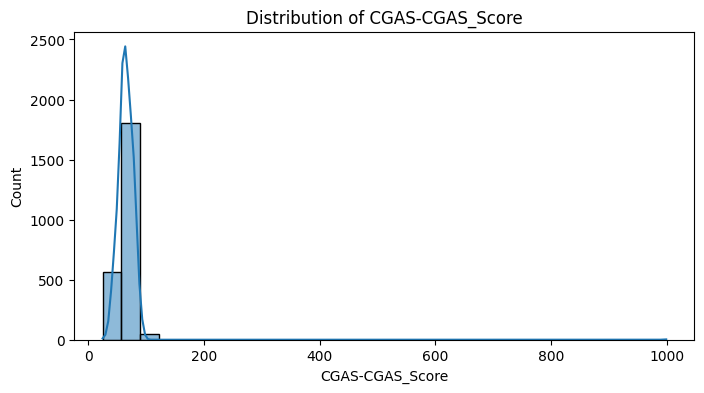


Value Counts for CGAS-Season:
CGAS-Season
Spring    697
Summer    656
Fall      635
Winter    567
Name: count, dtype: int64


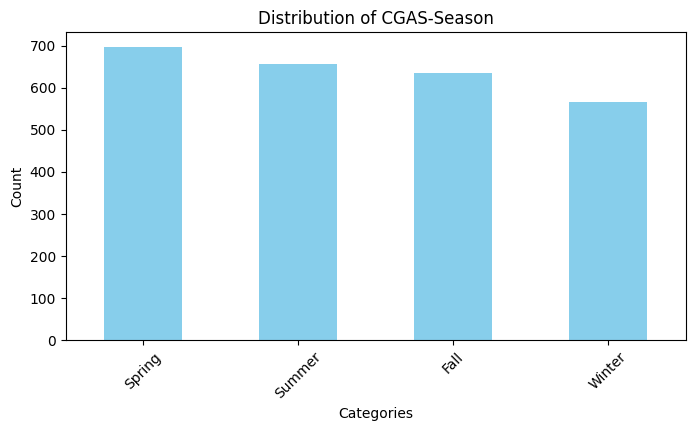

In [37]:
# General information

general_info(df_children_ass, name="Bio-electric Impedance Analysis")

# Classify variables based on type

qualitative_nominal_children_ass = ['CGAS-Season']

qualitative_ordinal_children_ass = []

quantitative_ratio_children_ass = [

    'CGAS-CGAS_Score'

]

quantitative_interval_children_ass = []



# Analyze numerical columns

numerical_columns_children_ass = quantitative_ratio_children_ass + quantitative_interval_children_ass

analyze_numerical(df_children_ass, numerical_columns_children_ass)

plot_numerical_distributions(df_children_ass, numerical_columns_children_ass)



# Analyze categorical columns

categorical_columns_children_ass = qualitative_nominal_children_ass + qualitative_ordinal_children_ass

analyze_categorical(df_children_ass, categorical_columns_children_ass)

plot_categorical_distributions(df_children_ass, categorical_columns_children_ass)

In [38]:
# Check rows where CGAS-Season is missing

missing_season = df_children_ass['CGAS-Season'].isnull()



# Check rows where CGAS-CGAS_Score is missing

missing_score = df_children_ass['CGAS-CGAS_Score'].isnull()



# Check if all rows missing 'CGAS-Season' are also missing 'CGAS-CGAS_Score'

missing_season_and_score = missing_season & missing_score

count_missing_season = missing_season.sum()

count_missing_both = missing_season_and_score.sum()



if count_missing_season == count_missing_both:

    print(f"All {count_missing_season} rows missing 'CGAS-Season' are also missing 'CGAS-CGAS_Score'.")

else:

    print(f"Not all rows missing 'CGAS-Season' are missing 'CGAS-CGAS_Score'.")

    print(f"Rows missing 'CGAS-Season': {count_missing_season}")

    print(f"Rows missing both: {count_missing_both}")

All 1405 rows missing 'CGAS-Season' are also missing 'CGAS-CGAS_Score'.


#### Key Insights



1. **General Information**:

   - The dataset contains **3960 entries** and **2 columns**: one categorical (`CGAS-Season`) and one numerical (`CGAS-CGAS_Score`).

   - **35.48% of rows completely missing values**.



2. **Missing Values**:

   - `CGAS-Season`: **35.48% missing**.

   - `CGAS-CGAS_Score`: **38.86% missing**.

   - **ALL the values missing in the season are also missing in the score**

3. **Numerical Column Analysis (`CGAS-CGAS_Score`)**:

   - Total non-null values: **2421**.

   - Mean score: **65.45**, with a standard deviation of **22.34**.

   - Minimum: **25**, Maximum: **999** (suggests a possible outlier).

   - Median (50%): **65**, with an interquartile range (IQR) from **59** (25%) to **75** (75%).



4. **Categorical Column Analysis (`CGAS-Season`)**:

   - Most common season: **Spring (697 entries)**.

   - Distribution across seasons is relatively balanced, with slightly fewer entries for **Winter (567 entries)**.



### Key Observations:

- **Missing Data**: A significant portion of data is missing, especially in `CGAS-CGAS_Score`.

- **Outlier in Numerical Data**: The maximum value of **999** in `CGAS-CGAS_Score` appears anomalous and warrants investigation.

- **Seasonal Distribution**: Distribution is relatively balanced, with slightly fewer records in Winter.

## Filter the Outlier


In [39]:
cgas_score_outlier = df_train_csv[df_train_csv['CGAS-CGAS_Score']>100]

In [40]:
# drop the outlier without dropping nans

df_train_csv.drop(cgas_score_outlier.index, inplace=True)

In [41]:
df_train_csv.groupby('Basic_Demos-Age')['CGAS-CGAS_Score'].count()

Basic_Demos-Age
5      71
6     253
7     279
8     307
9     301
10    262
11    194
12    179
13    136
14    122
15    103
16     74
17     62
18     39
19     12
20     11
21     13
22      2
Name: CGAS-CGAS_Score, dtype: int64

## Average CGAS Score by Age Group and SII

/tmp/ipykernel_23/3694142877.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_train_csv.groupby(['Age Group', 'Severity Impairment Index (SII)'], as_index=False)['CGAS-CGAS_Score'].mean()
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

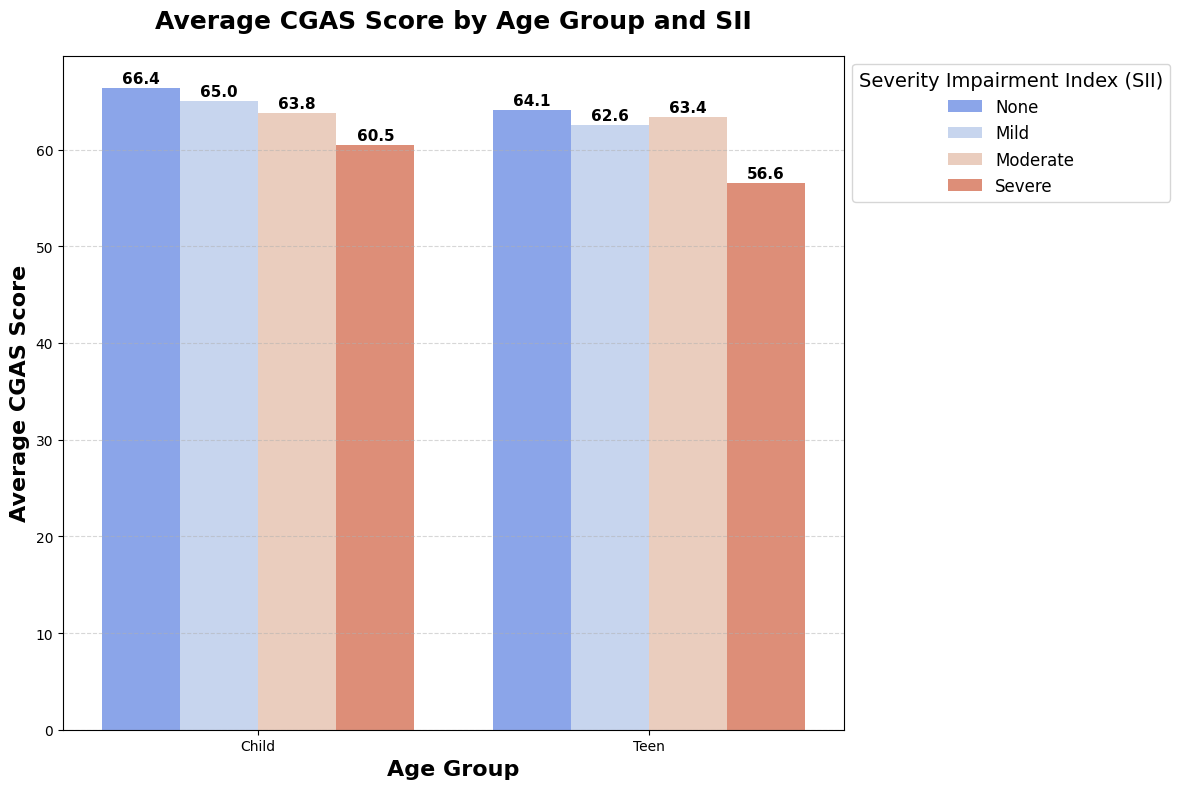

In [42]:
grouped_data = df_train_csv.groupby(['Age Group', 'Severity Impairment Index (SII)'], as_index=False)['CGAS-CGAS_Score'].mean()



grouped_data=grouped_data.rename(columns={

    'CGAS-CGAS_Score': 'Average CGAS Score'

})



sii_mapping = {0: 'None', 1: 'Mild', 2: 'Moderate', 3: 'Severe'}

grouped_data['Severity Impairment Index (SII)'] = grouped_data['Severity Impairment Index (SII)'].map(sii_mapping)

# Ensure 'SII Level' is categorical and sorted

sii_order = ['None', 'Mild', 'Moderate', 'Severe']



# --- 2. Grouped Bar Plot ---

plt.figure(figsize=(14, 8))



# Create the grouped barplot

sns.barplot(

    data=grouped_data,

    x='Age Group',

    y='Average CGAS Score',

    hue='Severity Impairment Index (SII)',

    palette='coolwarm',  # Use a clean color palette

    errorbar=None

)



# --- 3. Customizations ---

# Title and axis labels

plt.title("Average CGAS Score by Age Group and SII", fontsize=18, fontweight='bold', pad=20)

plt.xlabel("Age Group", fontsize=16, fontweight='bold')

plt.ylabel("Average CGAS Score", fontsize=16, fontweight='bold')



# Move legend outside the plot

plt.legend(

    title="Severity Impairment Index (SII)",

    title_fontsize=14,

    fontsize=12,

    loc='upper left',

    bbox_to_anchor=(1, 1)  # Move legend to the right of the plot

)



# Add values above the bars

for p in plt.gca().patches:

    height = p.get_height()

    if height > 0:  # Avoid text on empty bars

        plt.text(

            p.get_x() + p.get_width() / 2, height + 0.2,  # Slightly above the bar

            f"{height:.1f}",

            ha='center', va='bottom',

            fontsize=11, fontweight='bold', color='black'

        )



# Add gridlines for better readability

plt.grid(axis='y', linestyle='--', alpha=0.5)



# Adjust layout to make space for legend

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Shrink plot area to accommodate legend



# --- 4. Save and Show Plot ---

plt.savefig("CGAS_vs_AgeGroup_vs_SII.pdf", dpi=600, bbox_inches='tight')

plt.show()


# Describe: Demographics

In [43]:
# Apply Filters

instrument_filter = "Demographics"

df_demo, df_dict_demo = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_demo.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex
0,Fall,5,0
1,Summer,9,0
2,Summer,10,1
3,Winter,9,0
4,Spring,18,1


In [44]:
df_dict_demo

,Instrument,Field,Description,Type,Values,Value Labels
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"


Summary of Demographics:
<class 'pandas.core.frame.DataFrame'>
Index: 3959 entries, 0 to 3959
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Basic_Demos-Enroll_Season  3959 non-null   object
 1   Basic_Demos-Age            3959 non-null   int64 
 2   Basic_Demos-Sex            3959 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 123.7+ KB
None

Summary Statistics:
       Basic_Demos-Age  Basic_Demos-Sex
count      3959.000000      3959.000000
mean         10.433443         0.372569
std           3.575088         0.483550
min           5.000000         0.000000
25%           8.000000         0.000000
50%          10.000000         0.000000
75%          13.000000         1.000000
max          22.000000         1.000000

Missing Values Percentage:
Basic_Demos-Enroll_Season    0.0
Basic_Demos-Age              0.0
Basic_Demos-Sex              0.0
dtype: float64

 Totally Missing R

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


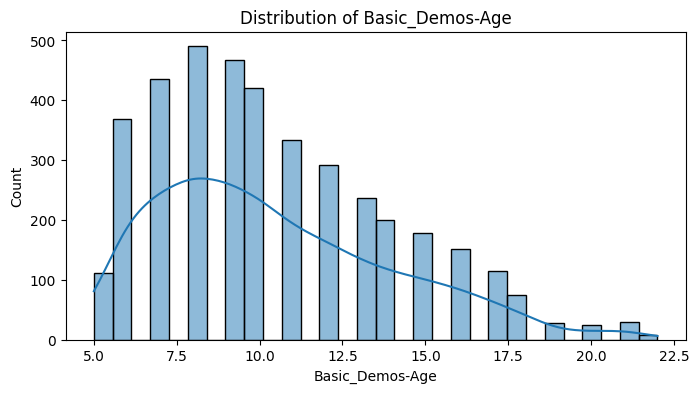


Value Counts for Basic_Demos-Enroll_Season:
Basic_Demos-Enroll_Season
Spring    1127
Winter     997
Summer     970
Fall       865
Name: count, dtype: int64

Value Counts for Basic_Demos-Sex:
Basic_Demos-Sex
0    2484
1    1475
Name: count, dtype: int64


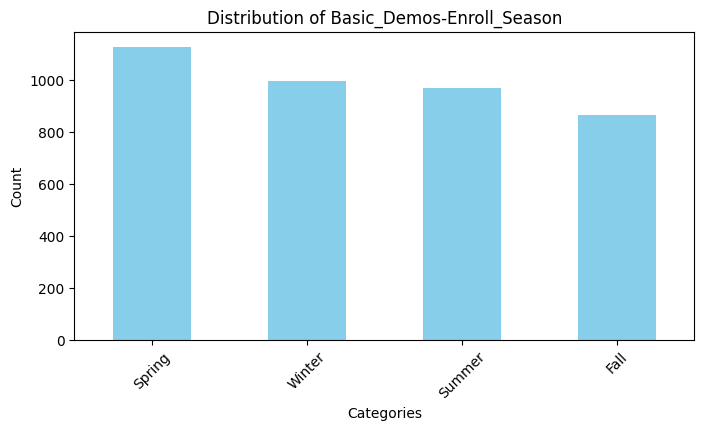

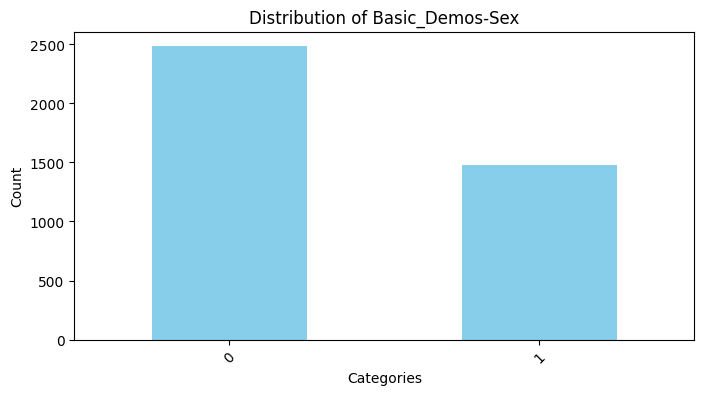

In [45]:
# General information

general_info(df_demo, name="Demographics")

# Classify variables based on type

qualitative_nominal_demo = ['Basic_Demos-Enroll_Season','Basic_Demos-Sex']

qualitative_ordinal_demo = []

quantitative_ratio_demo = [

    'Basic_Demos-Age'

]

quantitative_interval_demo = []



# Analyze numerical columns

numerical_columns_demo = quantitative_ratio_demo + quantitative_interval_demo

analyze_numerical(df_demo, numerical_columns_demo)

plot_numerical_distributions(df_demo, numerical_columns_demo)



# Analyze categorical columns

categorical_columns_demo = qualitative_nominal_demo + qualitative_ordinal_demo

analyze_categorical(df_demo, categorical_columns_demo)

plot_categorical_distributions(df_demo, categorical_columns_demo)

# Describe: FitnessGram Child


In [46]:
# Apply Filters

instrument_filter = "FitnessGram Child"

df_fitness_child, df_dict_fitness_child = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_fitness_child.head()

,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone
0,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0
1,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0
2,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0
3,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_dict_fitness_child

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


Summary of FitnessGram Child:
<class 'pandas.core.frame.DataFrame'>
Index: 3959 entries, 0 to 3959
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FGC-Season         3345 non-null   object 
 1   FGC-FGC_CU         2322 non-null   float64
 2   FGC-FGC_CU_Zone    2282 non-null   float64
 3   FGC-FGC_GSND       1074 non-null   float64
 4   FGC-FGC_GSND_Zone  1062 non-null   float64
 5   FGC-FGC_GSD        1074 non-null   float64
 6   FGC-FGC_GSD_Zone   1063 non-null   float64
 7   FGC-FGC_PU         2310 non-null   float64
 8   FGC-FGC_PU_Zone    2271 non-null   float64
 9   FGC-FGC_SRL        2305 non-null   float64
 10  FGC-FGC_SRL_Zone   2267 non-null   float64
 11  FGC-FGC_SRR        2307 non-null   float64
 12  FGC-FGC_SRR_Zone   2269 non-null   float64
 13  FGC-FGC_TL         2324 non-null   float64
 14  FGC-FGC_TL_Zone    2285 non-null   float64
dtypes: float64(14), object(1)
memory usage: 494.9+ 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


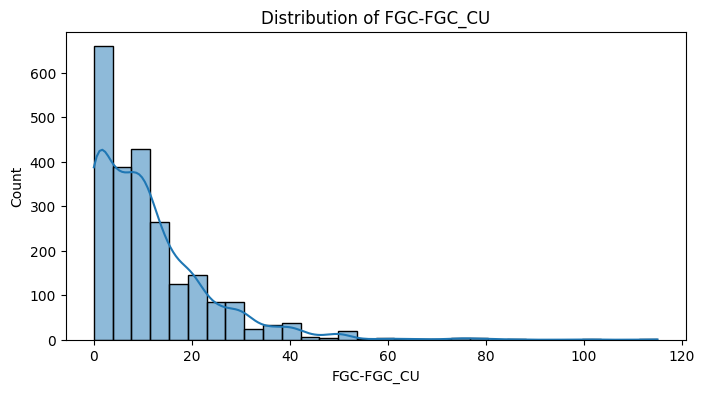

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


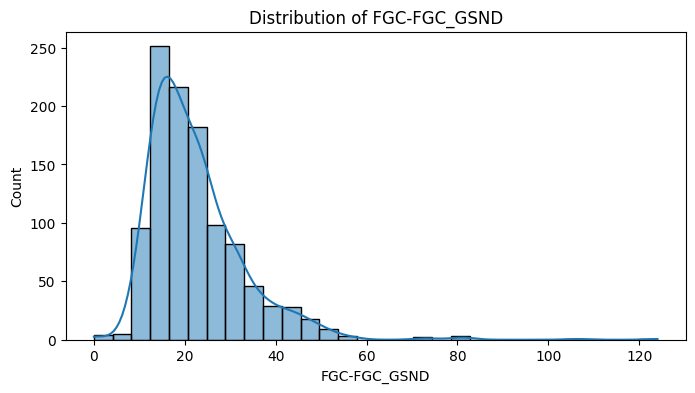

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


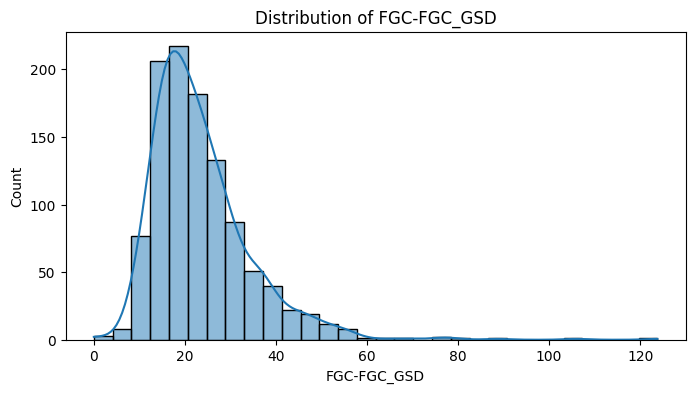

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


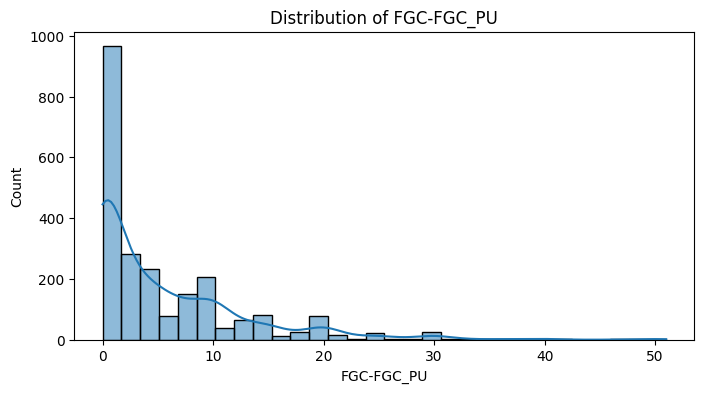

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


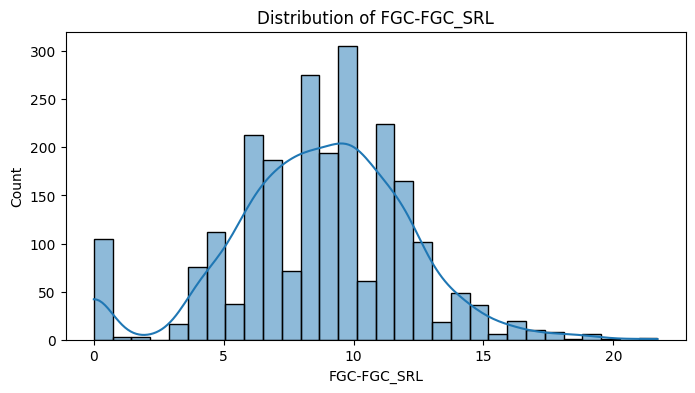

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


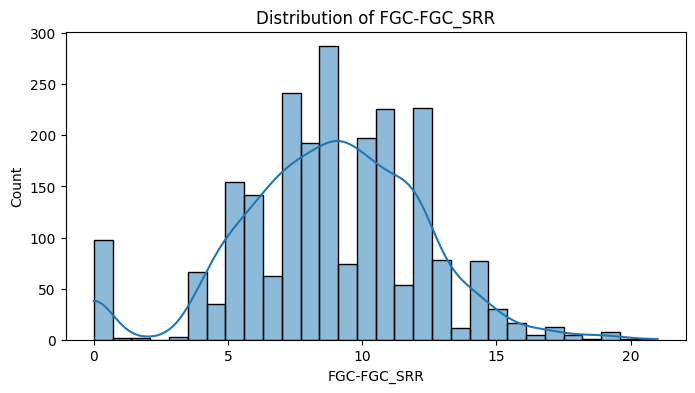

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


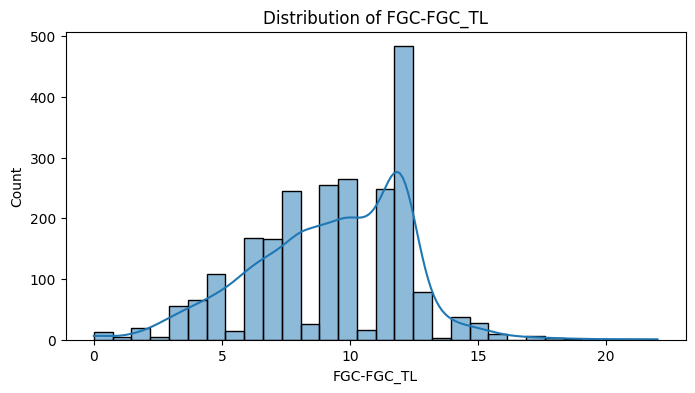


Value Counts for FGC-Season:
FGC-Season
Spring    993
Summer    844
Fall      762
Winter    746
Name: count, dtype: int64

Value Counts for FGC-FGC_CU_Zone:
FGC-FGC_CU_Zone
0.0    1195
1.0    1087
Name: count, dtype: int64

Value Counts for FGC-FGC_GSND_Zone:
FGC-FGC_GSND_Zone
2.0    633
1.0    305
3.0    124
Name: count, dtype: int64

Value Counts for FGC-FGC_GSD_Zone:
FGC-FGC_GSD_Zone
2.0    655
1.0    255
3.0    153
Name: count, dtype: int64

Value Counts for FGC-FGC_PU_Zone:
FGC-FGC_PU_Zone
0.0    1521
1.0     750
Name: count, dtype: int64

Value Counts for FGC-FGC_SRL_Zone:
FGC-FGC_SRL_Zone
1.0    1403
0.0     864
Name: count, dtype: int64

Value Counts for FGC-FGC_SRR_Zone:
FGC-FGC_SRR_Zone
1.0    1407
0.0     862
Name: count, dtype: int64

Value Counts for FGC-FGC_TL_Zone:
FGC-FGC_TL_Zone
1.0    1795
0.0     490
Name: count, dtype: int64


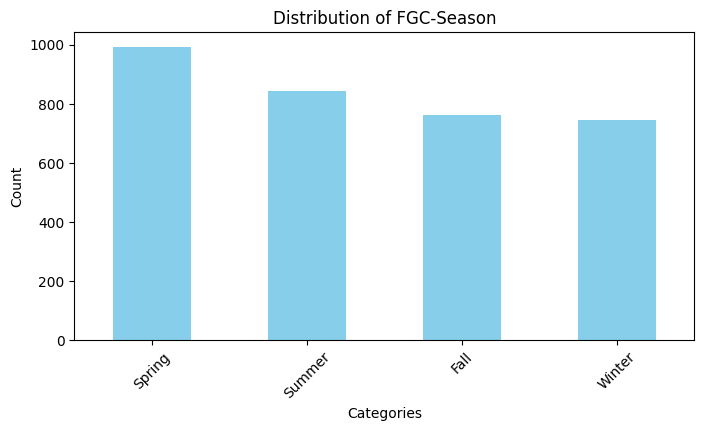

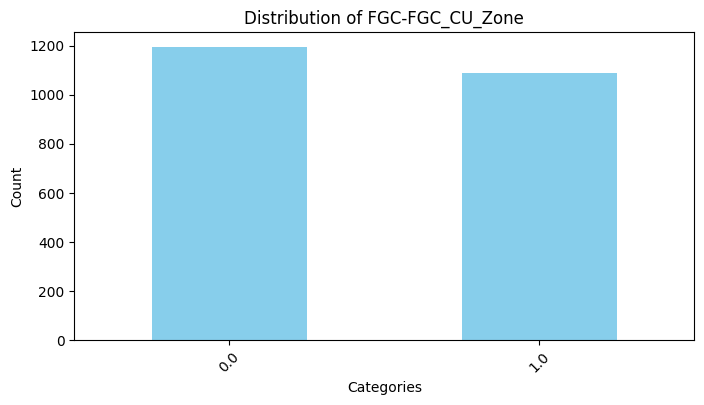

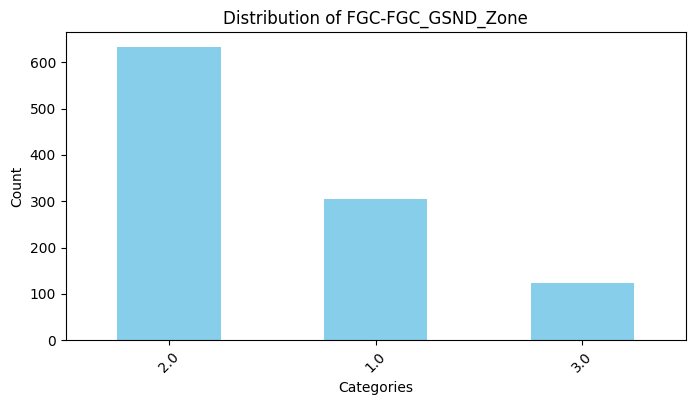

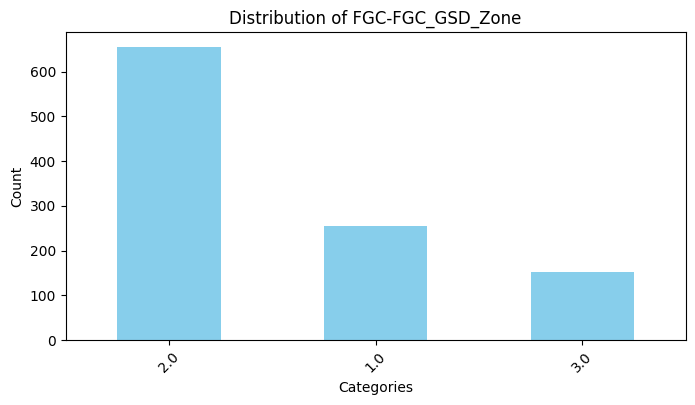

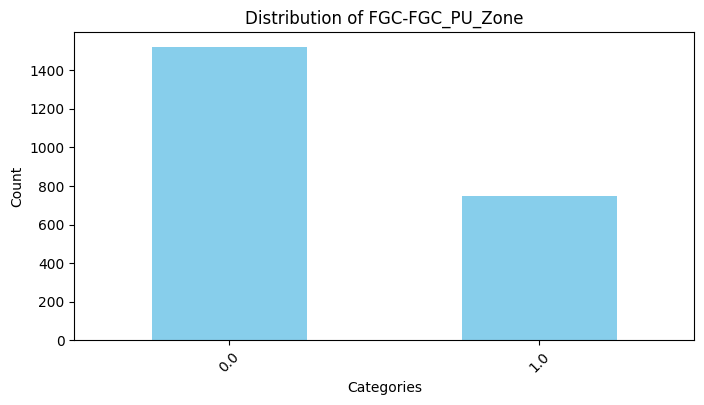

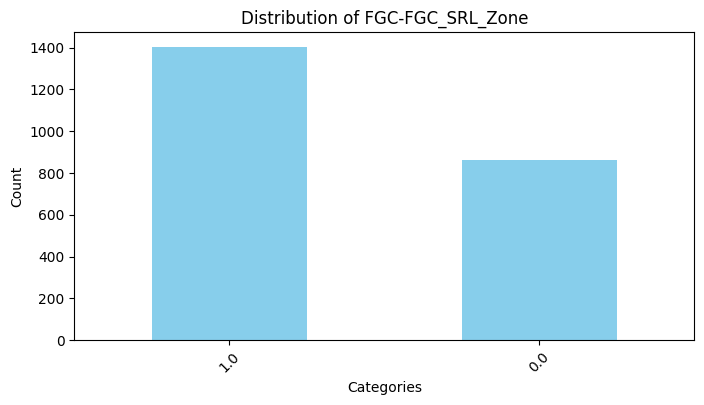

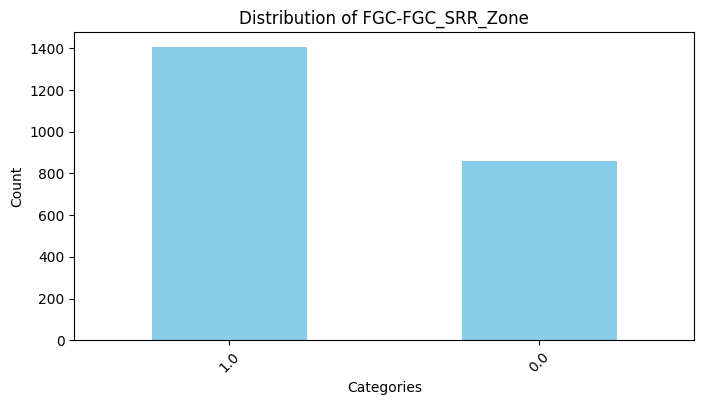

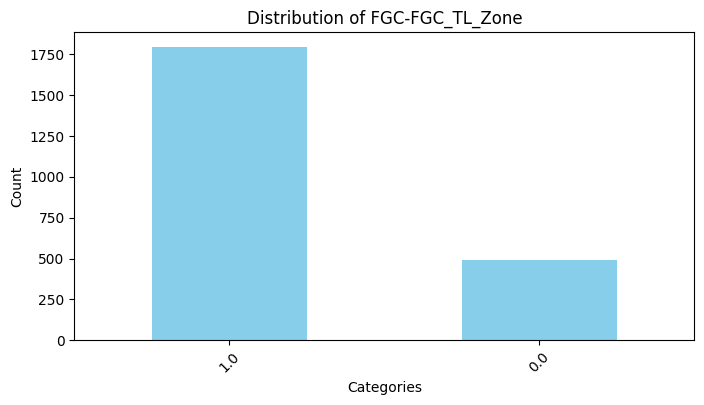

In [48]:
# General information

general_info(df_fitness_child, name="FitnessGram Child")

# Classify variables based on type

qualitative_nominal_fitness_child = ['FGC-Season']

qualitative_ordinal_fitness_child = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',"FGC-FGC_GSD_Zone", 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']

quantitative_ratio_fitness_child = [

    'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL'

]

quantitative_interval_fitness_child = []



# Analyze numerical columns

numerical_columns_fitness_child = quantitative_ratio_fitness_child + quantitative_interval_fitness_child

analyze_numerical(df_fitness_child, numerical_columns_fitness_child)

plot_numerical_distributions(df_fitness_child, numerical_columns_fitness_child)



# Analyze categorical columns

categorical_columns_fitness_child = qualitative_nominal_fitness_child + qualitative_ordinal_fitness_child

analyze_categorical(df_fitness_child, categorical_columns_fitness_child)

plot_categorical_distributions(df_fitness_child, categorical_columns_fitness_child)

#### Insights





1. **Missing Data**:

   - **15.51% of rows** are completely missing.

   - Highest missing percentages:

     - `FGC-FGC_GSND`: **72.88%**.

     - `FGC-FGC_GSND_Zone`: **73.18%**.

   - Lowest missing percentages:

     - `FGC-Season`: **15.51%**.

     - Other numerical columns: **41.31%–43.73%**.



2. **Numerical Column Analysis**:

   - **General Ranges**:

     - Most metrics have a minimum of **0**.

     - Maximum values range widely (e.g., `FGC-FGC_CU` max: **115**, `FGC-FGC_GSND` max: **124**).

   - **Descriptive Insights**:

     - `FGC-FGC_CU`: Mean **11.26**, Median **9**, StdDev **11.81**.

     - `FGC-FGC_TL`: Mean **9.25**, Median **10**, StdDev **2.99**.

   - **Outliers**:

     - Significant spread in `FGC-FGC_CU` and `FGC-FGC_GSND` suggests possible outliers.



4. **Categorical Column Analysis**:

   - **Enroll Season (`FGC-Season`)**:

     - Balanced distribution:

       - Spring: **993 entries** (most common).

       - Winter: **746 entries** (least common).



5. **Zone Value Counts**:

   - **FGC-FGC_CU_Zone**: Evenly split between `0.0` (**1195**) and `1.0` (**1087**).

   - **FGC-FGC_PU_Zone**: Majority `0.0` (**1521**), fewer `1.0` (**750**).

   - **FGC-FGC_SRL_Zone** and **FGC-FGC_SRR_Zone**:

     - `1.0` (1403–1407 entries) is more common than `0.0` (~860 entries).

   - **FGC-FGC_TL_Zone**:

     - `1.0` dominates (**1795 entries**) compared to `0.0` (**490 entries**).



---



Key Observations:

1. **Missing Data**:

   - High missingness in columns like `FGC-FGC_GSND` and `FGC-FGC_GSND_Zone` may impact analyses and requires handling.

   - `FGC-Season` has the lowest missingness among all columns.



2. **Numerical Data**:

   - `FGC-FGC_CU` and `FGC-FGC_GSND` show large variances, suggesting diverse or outlier data points.

   - Most numerical metrics follow expected distributions, with central tendencies clustered near their medians.



3. **Categorical Data**:

   - Enroll seasons are fairly balanced, with Spring as the most represented season.

   - Zone classifications are generally skewed towards one category (e.g., `1.0` in `FGC-FGC_SRL_Zone`).



---



Recommendations:

- **Outlier Detection**:

  - Investigate high variance in metrics like `FGC-FGC_CU` and `FGC-FGC_GSND`.

- **Missing Data Handling**:

  - Consider imputation strategies for missing numerical and categorical values, especially for columns with >40% missingness.

- **Balanced Analysis**:

  - Utilize categorical zones for comparative analyses as their distributions indicate potential separable patterns.

In [49]:
import pandas as pd

import numpy as np

from scipy.stats import f_oneway



def compute_correlation(df, numerical_columns, categorical_columns):

    """

    Analyze the correlation between numerical features and their associated categorical features.



    Parameters:

        df (pd.DataFrame): The dataset.

        numerical_columns (list): List of numerical column names.

        categorical_columns (list): List of categorical column names.



    Returns:

        pd.DataFrame: Correlation results including ANOVA F-statistic and Eta-squared.

    """

    results = []



    for num_col, cat_col in zip(numerical_columns, categorical_columns):

        # Drop missing values

        data = df[[num_col, cat_col]].dropna()



        # Group statistics

        groups = [data[num_col][data[cat_col] == category] for category in data[cat_col].unique()]



        # ANOVA F-statistic

        f_stat, p_value = f_oneway(*groups)



        # Eta-squared

        total_var = np.var(data[num_col], ddof=1)

        between_group_var = sum(len(group) * (np.mean(group) - np.mean(data[num_col]))**2 for group in groups) / len(data)

        eta_squared = between_group_var / total_var



        results.append({

            'Numerical Feature': num_col,

            'Categorical Feature': cat_col,

            'ANOVA F-statistic': f_stat,

            'p-value': p_value,

            'Eta-squared': eta_squared

        })



    return pd.DataFrame(results)



# Example Usage

numerical_columns = ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_TL']

categorical_columns = ['FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_TL_Zone']



correlation_results = compute_correlation(df_fitness_child, numerical_columns, categorical_columns)

print(correlation_results)


  Numerical Feature Categorical Feature  ANOVA F-statistic        p-value  \
0        FGC-FGC_CU     FGC-FGC_CU_Zone         791.723679  8.848355e-150   
1      FGC-FGC_GSND   FGC-FGC_GSND_Zone         103.005398   1.328970e-41   
2        FGC-FGC_PU     FGC-FGC_PU_Zone        2406.227951   0.000000e+00   
3       FGC-FGC_SRL    FGC-FGC_SRL_Zone        2837.049542   0.000000e+00   
4        FGC-FGC_TL     FGC-FGC_TL_Zone        1947.208438  4.299642e-308   

   Eta-squared  
0     0.257633  
1     0.162700  
2     0.514559  
3     0.555924  
4     0.460109  


# Describe: FitnessGram Vitals and Treadmill


In [50]:
# Apply Filters

instrument_filter = "FitnessGram Vitals and Treadmill"

df_fitness_vitals, df_dict_fitness_vitals = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_fitness_vitals.head()

,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,Fall,5.0,7.0,33.0
3,Summer,6.0,9.0,37.0
4,NaN,NaN,NaN,NaN


In [51]:
df_dict_fitness_vitals

,Instrument,Field,Description,Type,Values,Value Labels
14,FitnessGram Vitals and Treadmill,Fitness_Endurance-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
15,FitnessGram Vitals and Treadmill,Fitness_Endurance-Max_Stage,Maximum stage reached,int,NaN,NaN
16,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Mins,Exact time completed: Minutes,int,NaN,NaN
17,FitnessGram Vitals and Treadmill,Fitness_Endurance-Time_Sec,Exact time completed: Seconds,int,NaN,NaN


Summary of FitnessGram Child:
<class 'pandas.core.frame.DataFrame'>
Index: 3959 entries, 0 to 3959
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Fitness_Endurance-Season     1307 non-null   object 
 1   Fitness_Endurance-Max_Stage  743 non-null    float64
 2   Fitness_Endurance-Time_Mins  740 non-null    float64
 3   Fitness_Endurance-Time_Sec   740 non-null    float64
dtypes: float64(3), object(1)
memory usage: 154.6+ KB
None

Summary Statistics:
       Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
count                   743.000000                   740.000000   
mean                      4.989233                     7.370270   
std                       2.014072                     3.189662   
min                       0.000000                     0.000000   
25%                       4.000000                     6.000000   
50%                       5.000000     

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


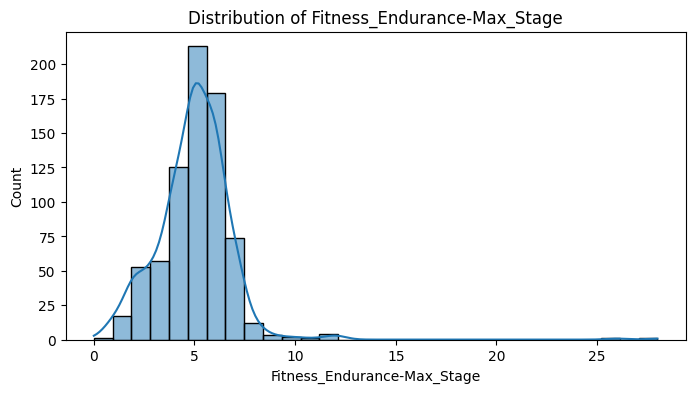

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


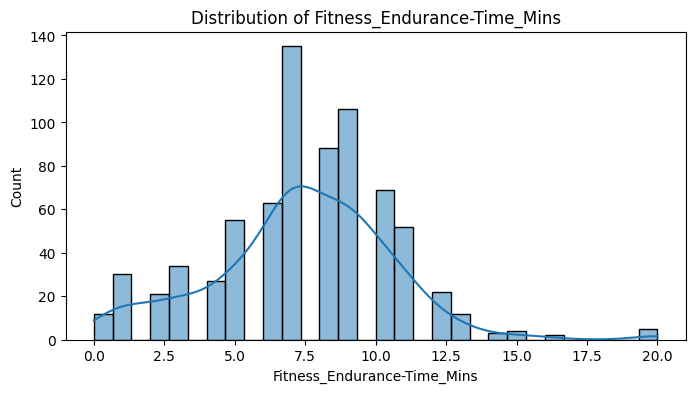

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


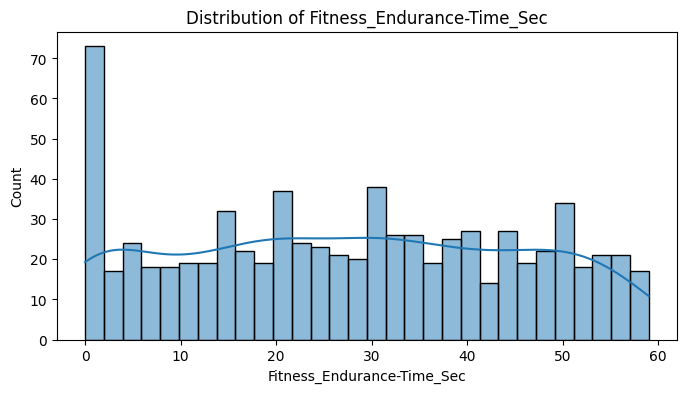


Value Counts for Fitness_Endurance-Season:
Fitness_Endurance-Season
Spring    385
Winter    338
Fall      331
Summer    253
Name: count, dtype: int64


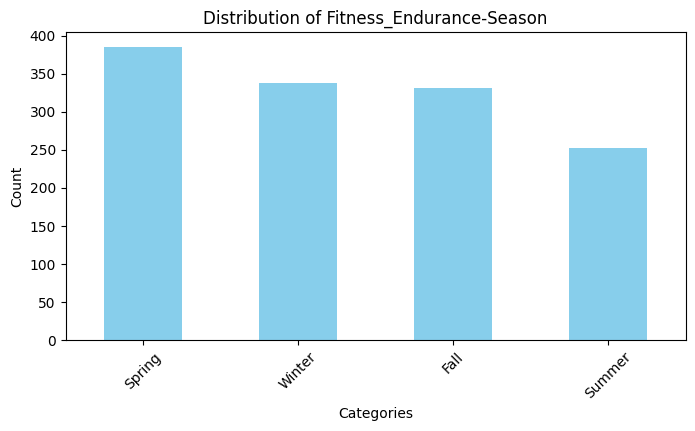

In [52]:
# General information

general_info(df_fitness_vitals, name="FitnessGram Child")

# Classify variables based on type

qualitative_nominal_fitness_vitals = ['Fitness_Endurance-Season']

qualitative_ordinal_fitness_vitals = []

quantitative_ratio_fitness_vitals = [

    'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',

]

quantitative_interval_fitness_vitals = []



# Analyze numerical columns

numerical_columns_fitness_vitals = quantitative_ratio_fitness_vitals + quantitative_interval_fitness_vitals

analyze_numerical(df_fitness_vitals, numerical_columns_fitness_vitals)

plot_numerical_distributions(df_fitness_vitals, numerical_columns_fitness_vitals)



# Analyze categorical columns

categorical_columns_fitness_vitals = qualitative_nominal_fitness_vitals + qualitative_ordinal_fitness_vitals

analyze_categorical(df_fitness_vitals, categorical_columns_fitness_vitals)

plot_categorical_distributions(df_fitness_vitals, categorical_columns_fitness_vitals)

In [53]:
# add minutes to seconds

df_fitness_vitals['Fitness_Endurance-Total'] = df_fitness_vitals['Fitness_Endurance-Time_Mins']*60 + df_fitness_vitals['Fitness_Endurance-Time_Sec']

df_fitness_vitals.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

/tmp/ipykernel_23/2050543372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fitness_vitals['Fitness_Endurance-Total'] = df_fitness_vitals['Fitness_Endurance-Time_Mins']*60 + df_fitness_vitals['Fitness_Endurance-Time_Sec']
/tmp/ipykernel_23/2050543372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fitness_vitals.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)


## Feature Engineer Total Endurance

In [54]:
df_train_csv['Fitness_Endurance-Total'] = df_train_csv['Fitness_Endurance-Time_Mins']*60 + df_train_csv['Fitness_Endurance-Time_Sec']

df_train_csv.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

In [55]:
df_test_csv['Fitness_Endurance-Total'] = df_test_csv['Fitness_Endurance-Time_Mins']*60 + df_test_csv['Fitness_Endurance-Time_Sec']

df_test_csv.drop(columns=['Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec'], inplace=True)

## Plot Max Stage with Total Endurance

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


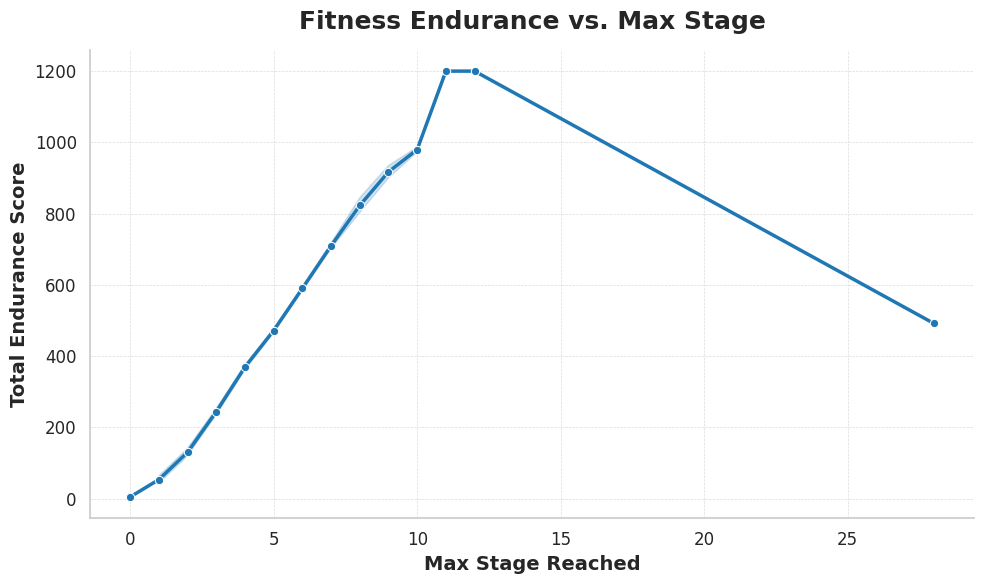

In [56]:
# Set a clean theme

sns.set_theme(style="whitegrid")



# Create the enhanced line plot

plt.figure(figsize=(10, 6))  # Adjust figure size

sns.lineplot(

    data=df_fitness_vitals,

    x='Fitness_Endurance-Max_Stage',

    y='Fitness_Endurance-Total',

    marker='o',       # Add markers to highlight points

    color='#1f77b4',  # Use a professional blue color

    linewidth=2.5,    # Increase line thickness

    linestyle='-',    # Solid line style

)



# Add titles and labels

plt.title('Fitness Endurance vs. Max Stage', fontsize=18, fontweight='bold', pad=15)

plt.xlabel('Max Stage Reached', fontsize=14, fontweight='bold')

plt.ylabel('Total Endurance Score', fontsize=14, fontweight='bold')



# Tweak ticks

plt.xticks(fontsize=12)

plt.yticks(fontsize=12)



# Add gridlines

plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)



# Remove top and right spines for a cleaner look

sns.despine()



# Show the final plot

plt.tight_layout()

plt.show()


In [57]:
# age with max stage

df_train_csv.groupby('Basic_Demos-Age')['Fitness_Endurance-Max_Stage'].mean()

Basic_Demos-Age
5          NaN
6     4.000000
7     5.007752
8     5.149254
9     5.283784
10    5.137681
11    4.931034
12    4.766667
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
Name: Fitness_Endurance-Max_Stage, dtype: float64

## This Feature is ONLY calculated for Children

## Remove Outliers


Max stage bigger than 12 is clearly outliers

In [58]:
endurance_outliers = df_fitness_vitals[df_fitness_vitals['Fitness_Endurance-Max_Stage']>12]

df_train_csv.drop(endurance_outliers.index, inplace=True)

# Describe: Internet Use


In [59]:
# Apply Filters

instrument_filter = "Internet Use"

df_internet_use, df_dict_internet_use = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_internet_use.head()

,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,Fall,3.0
1,Summer,0.0
2,Summer,2.0
3,Winter,0.0
4,NaN,NaN


In [60]:
df_dict_internet_use

,Instrument,Field,Description,Type,Values,Value Labels
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
80,Internet Use,PreInt_EduHx-computerinternet_hoursday,Hours of using computer/internet,categorical int,"0,1,2,3","0=Less than 1h/day, 1=Around 1h/day, 2=Around ..."


Summary of Internet Use:
<class 'pandas.core.frame.DataFrame'>
Index: 3957 entries, 0 to 3959
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   PreInt_EduHx-Season                     3537 non-null   object 
 1   PreInt_EduHx-computerinternet_hoursday  3298 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.7+ KB
None

Summary Statistics:
       PreInt_EduHx-computerinternet_hoursday
count                             3298.000000
mean                                 1.060643
std                                  1.094541
min                                  0.000000
25%                                  0.000000
50%                                  1.000000
75%                                  2.000000
max                                  3.000000

Missing Values Percentage:
PreInt_EduHx-Season                       0.106141
PreInt_EduHx-computerinter

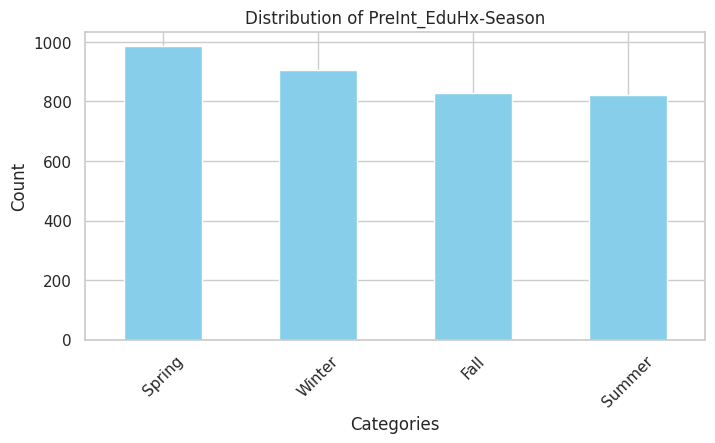

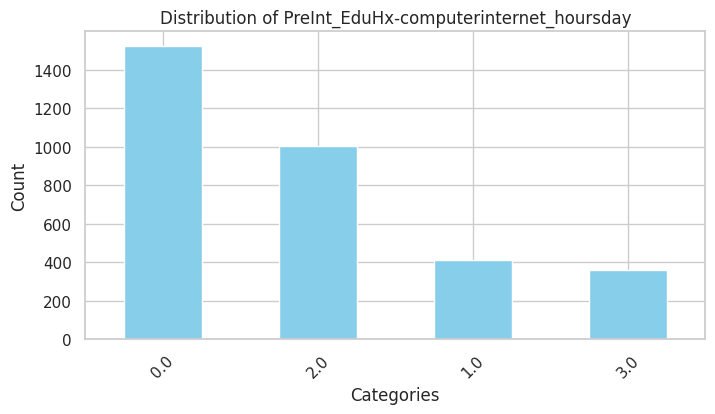

In [61]:
# General information

general_info(df_internet_use, name="Internet Use")

# Classify variables based on type

qualitative_nominal_internet_use = ['PreInt_EduHx-Season']

qualitative_ordinal_internet_use = ['PreInt_EduHx-computerinternet_hoursday']

quantitative_ratio_internet_use = [

]

quantitative_interval_internet_use= []



# Analyze categorical columns

categorical_columns_internet_use = qualitative_nominal_internet_use+ qualitative_ordinal_internet_use

analyze_categorical(df_internet_use, categorical_columns_internet_use)

plot_categorical_distributions(df_internet_use, categorical_columns_internet_use)

# Describe: Physical Activity Questionnaire (Adolescents)


In [62]:
# Apply Filters

instrument_filter = "Physical Activity Questionnaire (Adolescents)"

df_physical_adol, df_dict_physical_adol= filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_physical_adol.describe()

,PAQ_A-PAQ_A_Total
count,475.000000
mean,2.178853
std,0.849476
min,0.660000
25%,1.490000
50%,2.010000
75%,2.780000
max,4.710000


Summary of Physical Activity Questionnaire (Adolescents):
<class 'pandas.core.frame.DataFrame'>
Index: 3957 entries, 0 to 3959
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PAQ_A-Season       475 non-null    object 
 1   PAQ_A-PAQ_A_Total  475 non-null    float64
dtypes: float64(1), object(1)
memory usage: 92.7+ KB
None

Summary Statistics:
       PAQ_A-PAQ_A_Total
count         475.000000
mean            2.178853
std             0.849476
min             0.660000
25%             1.490000
50%             2.010000
75%             2.780000
max             4.710000

Missing Values Percentage:
PAQ_A-Season         0.87996
PAQ_A-PAQ_A_Total    0.87996
dtype: float64

 Totally Missing Rows Percentage:
88.00

Descriptive Statistics for Numerical Columns:
       PAQ_A-PAQ_A_Total
count         475.000000
mean            2.178853
std             0.849476
min             0.660000
25%             1.490000
50%   

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


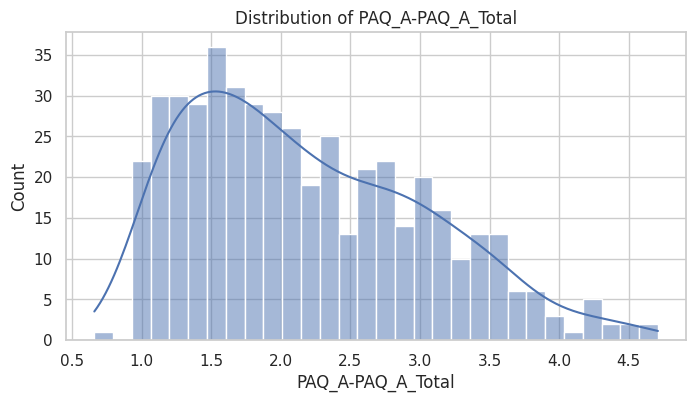


Value Counts for PAQ_A-Season:
PAQ_A-Season
Winter    137
Spring    123
Summer    117
Fall       98
Name: count, dtype: int64


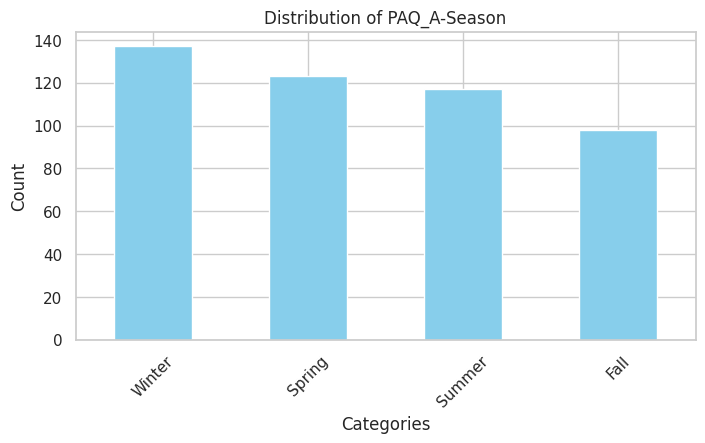

In [63]:
# General information

general_info(df_physical_adol, name="Physical Activity Questionnaire (Adolescents)")

# Classify variables based on type

qualitative_nominal_physical_adol = ['PAQ_A-Season']

qualitative_ordinal_physical_adol = []

quantitative_ratio_physical_adol = [

    'PAQ_A-PAQ_A_Total'

]

quantitative_interval_physical_adol = []



# Analyze numerical columns

numerical_columns_physical_adol = quantitative_ratio_physical_adol + quantitative_interval_physical_adol

analyze_numerical(df_physical_adol, numerical_columns_physical_adol)

plot_numerical_distributions(df_physical_adol, numerical_columns_physical_adol)



# Analyze categorical columns

categorical_columns_physical_adol = qualitative_nominal_physical_adol + qualitative_ordinal_physical_adol

analyze_categorical(df_physical_adol, categorical_columns_physical_adol)

plot_categorical_distributions(df_physical_adol, categorical_columns_physical_adol)

## As expected, for adolescentes, we have data from 13 to 18 years old.

In [64]:
# group by age

df_train_csv.groupby('Basic_Demos-Age')['PAQ_A-PAQ_A_Total'].mean()

Basic_Demos-Age
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13    1.980000
14    2.370134
15    2.296134
16    2.099118
17    2.018517
18    1.954114
19         NaN
20         NaN
21         NaN
22         NaN
Name: PAQ_A-PAQ_A_Total, dtype: float64

In [65]:
# group by age

df_train_csv.groupby('Basic_Demos-Age')['PAQ_C-PAQ_C_Total'].mean()

Basic_Demos-Age
5          NaN
6          NaN
7     2.602500
8     2.514592
9     2.643034
10    2.589342
11    2.624300
12    2.589338
13    2.575844
14    2.467085
15         NaN
16         NaN
17    2.021000
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
Name: PAQ_C-PAQ_C_Total, dtype: float64

In [66]:
rows_wanted = df_train_csv[df_train_csv['Basic_Demos-Age']>14][['Basic_Demos-Age','PAQ_C-PAQ_C_Total']].dropna()

print(rows_wanted)

# get PAQ_A-PAQ_A_Total for these rows

df_train_csv.loc[rows_wanted.index, 'PAQ_A-PAQ_A_Total']

      Basic_Demos-Age  PAQ_C-PAQ_C_Total
2648               17              2.021


2648   NaN
Name: PAQ_A-PAQ_A_Total, dtype: float64

As we can see, we have only one mistake.

## Remove any rows that have children above 16 with PAQ_C-PAQ_C_Total value

In [67]:
rows_to_drop = df_train_csv[df_train_csv['Basic_Demos-Age']>14][['Basic_Demos-Age','PAQ_C-PAQ_C_Total']].dropna()

print(f"Rows to drop: {len(rows_to_drop)}")

df_train_csv.drop(rows_to_drop.index, inplace=True)

Rows to drop: 1


## **HOWEVER** we have one data point for a child -13 years old- that has data in both features

In [68]:
df_train_csv[df_train_csv['PAQ_C-PAQ_C_Total'].notna() & df_train_csv['PAQ_A-PAQ_A_Total'].notna()]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,Severity Impairment Index (SII),Age Group,Calculated-BMI,Fitness_Endurance-Total
3331,d74e4d7c,Winter,13,1,NaN,NaN,Summer,68.75,162.0,NaN,70.0,62.0,118.0,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.27,Spring,2.32,Winter,52.0,72.0,Winter,3.0,1.0,Child,24.094889,NaN


Given that it is on the borderline between children and adolescents, we can choose to put it with either.

## Keep the two features but know that we will need to models.

In [69]:
# # merge PAQ_A-PAQ_A_Total and PAQ_C-PAQ_C_Total based on one of their values

# df_train_csv['PAQ_Total'] = df_train_csv['PAQ_A-PAQ_A_Total'].fillna(df_train_csv['PAQ_C-PAQ_C_Total'])

# df_train_csv = df_train_csv.drop(columns=['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'], errors='ignore')

# Describe: Physical Activity Questionnaire (Children)


In [70]:
# Apply Filters

instrument_filter = "Physical Activity Questionnaire (Children)"

df_physical_children, df_dict_physical_children= filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_physical_children.head()

,PAQ_C-Season,PAQ_C-PAQ_C_Total
0,NaN,NaN
1,Fall,2.340
2,Summer,2.170
3,Winter,2.451
4,NaN,NaN


Summary of Physical Activity Questionnaire (Children):
<class 'pandas.core.frame.DataFrame'>
Index: 3956 entries, 0 to 3959
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PAQ_C-Season       1718 non-null   object 
 1   PAQ_C-PAQ_C_Total  1718 non-null   float64
dtypes: float64(1), object(1)
memory usage: 92.7+ KB
None

Summary Statistics:
       PAQ_C-PAQ_C_Total
count        1718.000000
mean            2.589833
std             0.784387
min             0.580000
25%             2.020000
50%             2.540000
75%             3.160000
max             4.790000

Missing Values Percentage:
PAQ_C-Season         0.565723
PAQ_C-PAQ_C_Total    0.565723
dtype: float64

 Totally Missing Rows Percentage:
56.57

Descriptive Statistics for Numerical Columns:
       PAQ_C-PAQ_C_Total
count        1718.000000
mean            2.589833
std             0.784387
min             0.580000
25%             2.020000
50%    

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


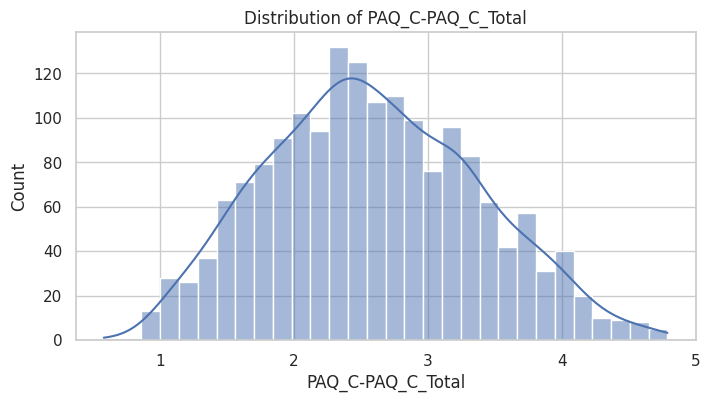


Value Counts for PAQ_C-Season:
PAQ_C-Season
Spring    506
Winter    468
Summer    391
Fall      353
Name: count, dtype: int64


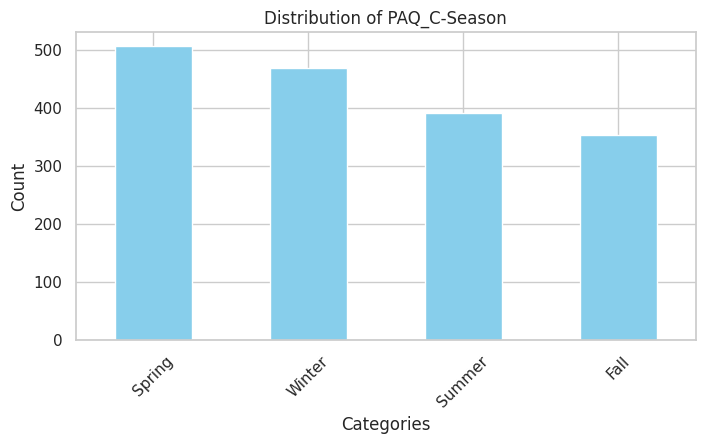

In [71]:
# General information

general_info(df_physical_children, name="Physical Activity Questionnaire (Children)")

# Classify variables based on type

qualitative_nominal_physical_children= ['PAQ_C-Season']

qualitative_ordinal_physical_children = []

quantitative_ratio_physical_children = [

    'PAQ_C-PAQ_C_Total'

]

quantitative_interval_physical_children = []



# Analyze numerical columns

numerical_columns_physical_children= quantitative_ratio_physical_children + quantitative_interval_physical_children

analyze_numerical(df_physical_children, numerical_columns_physical_children)

plot_numerical_distributions(df_physical_children, numerical_columns_physical_children)



# Analyze categorical columns

categorical_columns_physical_children = qualitative_nominal_physical_children + qualitative_ordinal_physical_children

analyze_categorical(df_physical_children, categorical_columns_physical_children)

plot_categorical_distributions(df_physical_children, categorical_columns_physical_children)

In [72]:
# select all features with season

season_columns = df_train_csv.columns[df_train_csv.columns.str.contains('Season')]

# Describe:Physical Measures


## Drop Height and Weight

Given that we have data for Bio-electric impedance analysis, I believe we should drop features like BMI, Height and Weight since they are redundent.

[source](https://pmc.ncbi.nlm.nih.gov/articles/PMC6345442/#:~:text=BMI%20is%20the%20most%20commonly,method%20for%20analyzing%20body%20composition.)

In [73]:
df_train_csv.drop(columns=['Physical-Height', 'Physical-Weight'], inplace=True)

In [74]:
df_test_csv.drop(columns=['Physical-Height', 'Physical-Weight'], inplace=True)

In [75]:
# drop fro df_dict_csv where field is physical bmi

df_dict_csv = df_dict_csv[df_dict_csv['Field'] != 'Physical-BMI']

df_dict_csv = df_dict_csv[df_dict_csv['Field'] != 'Physical-Height']

df_dict_csv = df_dict_csv[df_dict_csv['Field'] != 'Physical-Weight']

In [76]:
# Apply Filters

instrument_filter = "Physical Measures"

df_physical_measures, df_dict_physical_measures= filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_physical_measures.head()

,Physical-Season,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
0,Fall,NaN,NaN,NaN,NaN
1,Fall,22.0,75.0,70.0,122.0
2,Fall,NaN,65.0,94.0,117.0
3,Summer,NaN,60.0,97.0,117.0
4,NaN,NaN,NaN,NaN,NaN


Summary of Physical Measures:
<class 'pandas.core.frame.DataFrame'>
Index: 3956 entries, 0 to 3959
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Physical-Season               3306 non-null   object 
 1   Physical-Waist_Circumference  898 non-null    float64
 2   Physical-Diastolic_BP         2952 non-null   float64
 3   Physical-HeartRate            2965 non-null   float64
 4   Physical-Systolic_BP          2952 non-null   float64
dtypes: float64(4), object(1)
memory usage: 185.4+ KB
None

Summary Statistics:
       Physical-Waist_Circumference  Physical-Diastolic_BP  \
count                    898.000000            2952.000000   
mean                      27.278508              69.650407   
std                        5.567287              13.614671   
min                       18.000000               0.000000   
25%                       23.000000              61.000000   
50% 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


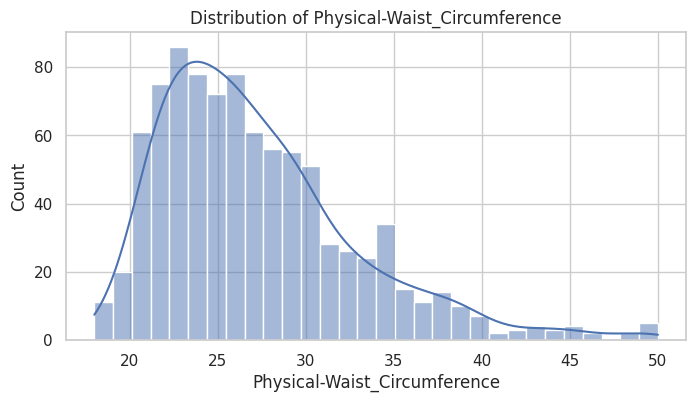

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


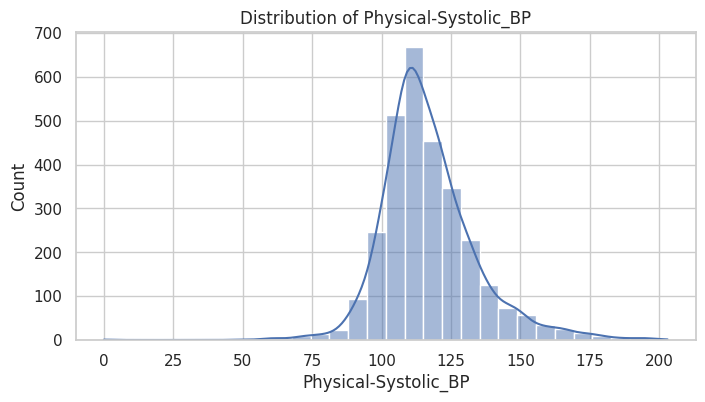

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


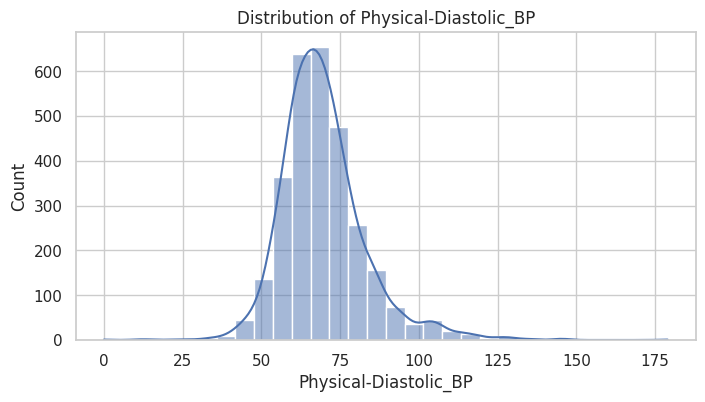

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


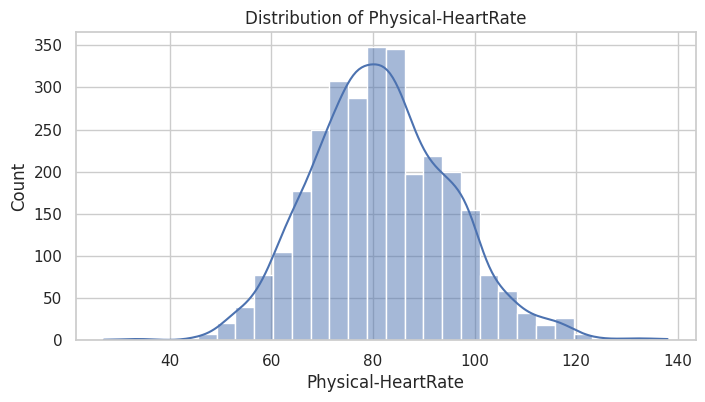


Value Counts for Physical-Season:
Physical-Season
Spring    927
Winter    803
Summer    791
Fall      785
Name: count, dtype: int64


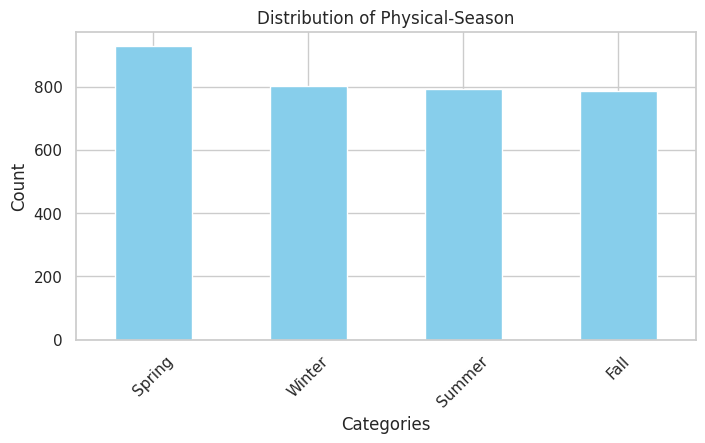

In [77]:
# General information

general_info(df_physical_measures, name="Physical Measures")

# Classify variables based on type

qualitative_nominal_physical_measures = ['Physical-Season']

qualitative_ordinal_physical_measures = []

quantitative_ratio_physical_measures = ['Physical-Waist_Circumference', 'Physical-Systolic_BP', 'Physical-Diastolic_BP', 'Physical-HeartRate']



quantitative_interval_physical_measures = []



# Analyze numerical columns

numerical_columns_physical_measures = quantitative_ratio_physical_measures + quantitative_interval_physical_measures

analyze_numerical(df_physical_measures, numerical_columns_physical_measures)

plot_numerical_distributions(df_physical_measures, numerical_columns_physical_measures)



# Analyze categorical columns

categorical_columns_physical_measures = qualitative_nominal_physical_measures + qualitative_ordinal_physical_measures

analyze_categorical(df_physical_measures, categorical_columns_physical_measures)

plot_categorical_distributions(df_physical_measures, categorical_columns_physical_measures)

## Identifying outliers

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


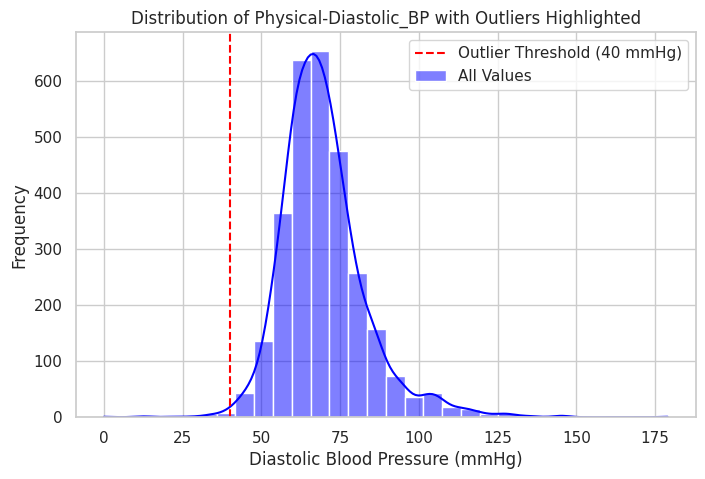

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


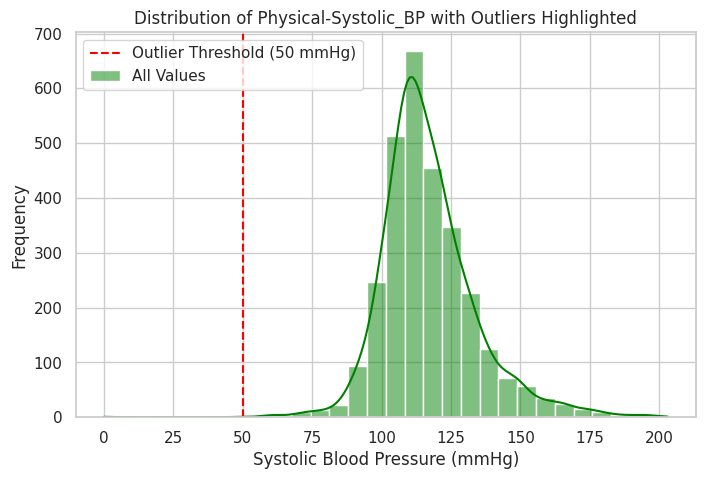

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


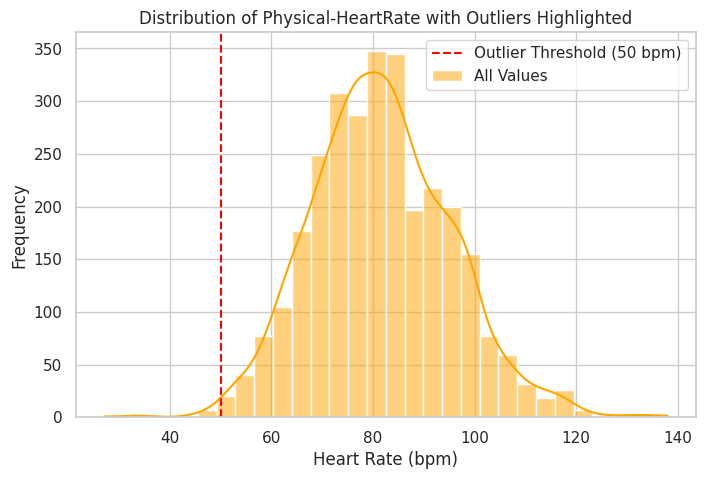

In [78]:
# Identifying outliers

diastolic_outliers = df_physical_measures[df_physical_measures['Physical-Diastolic_BP'] < 40]

systolic_outliers = df_physical_measures[df_physical_measures['Physical-Systolic_BP'] < 50]

low_heart_rate = df_physical_measures.loc[df_physical_measures['Physical-HeartRate'] < 50, 'Physical-HeartRate']



# Plot 1: Distribution of Diastolic BP with Highlighted Outliers

plt.figure(figsize=(8, 5))

sns.histplot(df_physical_measures['Physical-Diastolic_BP'], bins=30, color='blue', label='All Values', kde=True)

plt.axvline(40, color='red', linestyle='--', label='Outlier Threshold (40 mmHg)')

plt.title('Distribution of Physical-Diastolic_BP with Outliers Highlighted')

plt.xlabel('Diastolic Blood Pressure (mmHg)')

plt.ylabel('Frequency')

plt.legend()

plt.show()



# Plot 2: Distribution of Systolic BP with Highlighted Outliers

plt.figure(figsize=(8, 5))

sns.histplot(df_physical_measures['Physical-Systolic_BP'], bins=30, color='green', label='All Values', kde=True)

plt.axvline(50, color='red', linestyle='--', label='Outlier Threshold (50 mmHg)')

plt.title('Distribution of Physical-Systolic_BP with Outliers Highlighted')

plt.xlabel('Systolic Blood Pressure (mmHg)')

plt.ylabel('Frequency')

plt.legend()

plt.show()



# Improved Plot 3: Histogram with Highlighted Outliers for Heart Rate



plt.figure(figsize=(8, 5))

sns.histplot(df_physical_measures['Physical-HeartRate'], bins=30, color='orange', label='All Values', kde=True)

plt.axvline(50, color='red', linestyle='--', label='Outlier Threshold (50 bpm)')

plt.title('Distribution of Physical-HeartRate with Outliers Highlighted')

plt.xlabel('Heart Rate (bpm)')

plt.ylabel('Frequency')

plt.legend()

plt.show()






## Convert Outliers to NaN

In [79]:


df_train_csv.loc[df_train_csv['Physical-Diastolic_BP']<50, 'Physical-Diastolic_BP'] = np.nan

df_train_csv.loc[df_train_csv['Physical-HeartRate']<50, 'Physical-HeartRate'] = np.nan

df_train_csv.loc[df_train_csv['Physical-Systolic_BP']<50, 'Physical-Systolic_BP'] = np.nan


### Insights



2. **Physical-Diastolic_BP**:

   - Values like `20.0` and especially `11.0` are **critically low**, even for children. These may be measurement errors or outliers. Context is crucial:

     - During exercise, diastolic pressure may decrease slightly, but it doesn’t reach such low levels in healthy individuals.

     - If you have no way to validate the data, consider setting these values to `NaN`.



3. **Physical-HeartRate**:

   - Values like `39.0` bpm appear **unrealistic** for an 8–10-year-old during exercise. A normal exercise heart rate for children in this age range is typically **120–160 bpm**, depending on intensity.

   - These extreme values (`39.0`) are likely errors and should be set to `NaN`.



4. **Physical-Systolic_BP**:

   - Values like `49.0` mmHg are highly unusual and almost certainly erroneous for a child.

   - Children typically have systolic pressures between **90–120 mmHg**, and exercise can increase this slightly. `49.0` likely needs correction or should be set to `NaN`.


# Describe: Physical Activity Questionnaire (Sleep Disturbance Scale)


In [80]:
# Apply Filters

instrument_filter = "Sleep Disturbance Scale"

df_sleep, df_dict_sleep = filter_by_instrument(df_train_csv, df_dict_csv, instrument_filter)

df_sleep.head()

,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T
0,NaN,NaN,NaN
1,Fall,46.0,64.0
2,Fall,38.0,54.0
3,Summer,31.0,45.0
4,NaN,NaN,NaN


In [81]:
df_sleep

,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T
0,NaN,NaN,NaN
1,Fall,46.0,64.0
2,Fall,38.0,54.0
3,Summer,31.0,45.0
4,NaN,NaN,NaN
...,...,...,...
3955,Winter,35.0,50.0
3956,NaN,NaN,NaN
3957,Winter,56.0,77.0
3958,Spring,33.0,47.0


Summary of Sleep Disturbance Scale:
<class 'pandas.core.frame.DataFrame'>
Index: 3956 entries, 0 to 3959
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SDS-Season         2616 non-null   object 
 1   SDS-SDS_Total_Raw  2607 non-null   float64
 2   SDS-SDS_Total_T    2604 non-null   float64
dtypes: float64(2), object(1)
memory usage: 123.6+ KB
None

Summary Statistics:
       SDS-SDS_Total_Raw  SDS-SDS_Total_T
count        2607.000000      2604.000000
mean           41.090526        57.765745
std            10.431236        13.200908
min            17.000000        38.000000
25%            33.000000        47.000000
50%            39.000000        55.000000
75%            46.000000        64.000000
max            96.000000       100.000000

Missing Values Percentage:
SDS-Season           0.338726
SDS-SDS_Total_Raw    0.341001
SDS-SDS_Total_T      0.341759
dtype: float64

 Totally Missing Rows Percentag

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


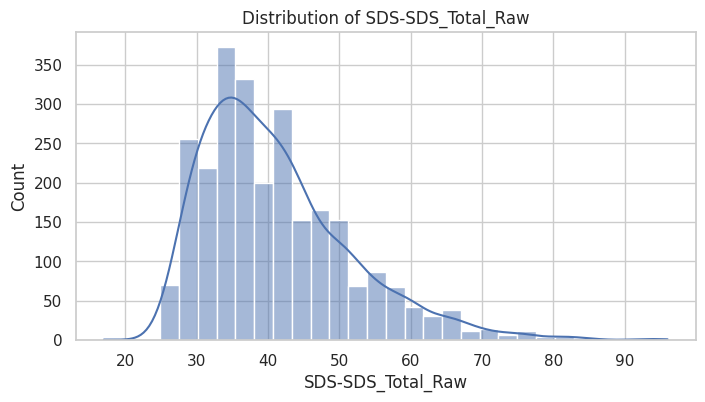

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


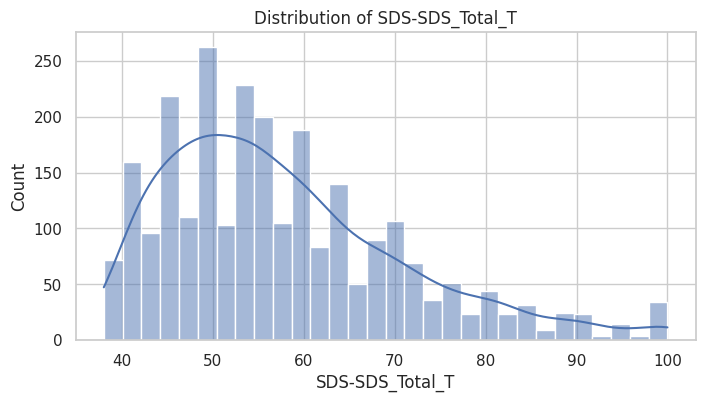


Value Counts for SDS-Season:
SDS-Season
Spring    710
Winter    652
Summer    635
Fall      619
Name: count, dtype: int64


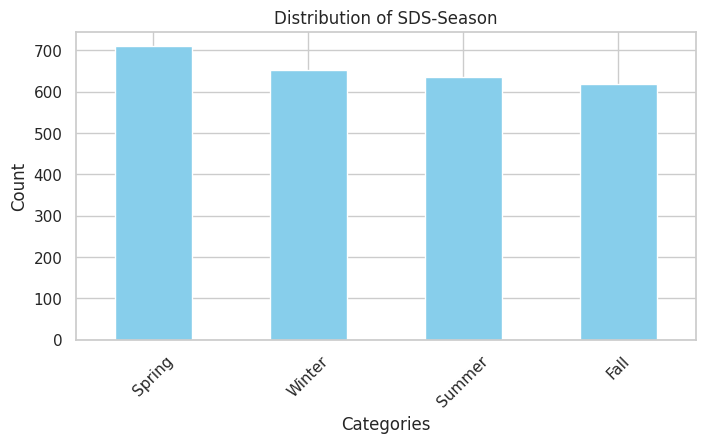

In [82]:
# General information

general_info(df_sleep, name="Sleep Disturbance Scale")

# Classify variables based on type

qualitative_nominal_sleep = ['SDS-Season']

qualitative_ordinal_sleep = []

quantitative_ratio_sleep = [

    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'

]

quantitative_interval_sleep = []



# Analyze numerical columns

numerical_columns_sleep = quantitative_ratio_sleep + quantitative_interval_sleep

analyze_numerical(df_sleep, numerical_columns_sleep)

plot_numerical_distributions(df_sleep, numerical_columns_sleep)



# Analyze categorical columns

categorical_columns_sleep= qualitative_nominal_sleep + qualitative_ordinal_sleep

analyze_categorical(df_sleep, categorical_columns_sleep)

plot_categorical_distributions(df_sleep, categorical_columns_sleep)

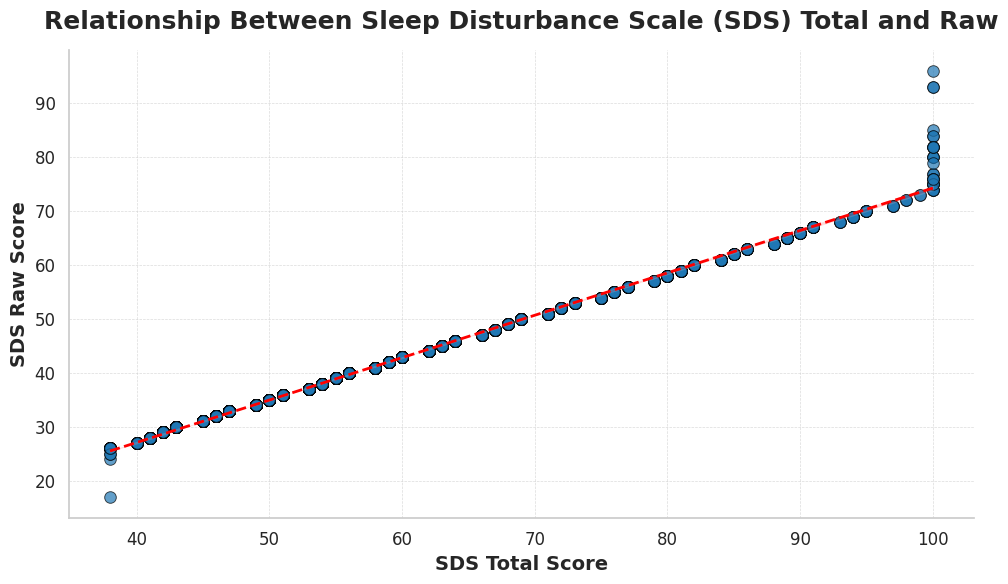

In [83]:


# Set a clean theme

sns.set_theme(style="whitegrid")



# Create the scatter plot with enhancements

plt.figure(figsize=(10, 6))  # Adjust figure size

sns.scatterplot(

    data=df_sleep,

    x='SDS-SDS_Total_T',

    y='SDS-SDS_Total_Raw',

    color='#1f77b4',  # Professional blue color

    alpha=0.7,        # Transparency for overlapping points

    s=70,             # Marker size

    edgecolor='black' # Add black edge to points for clarity

)



# Add a regression line for trend

sns.regplot(

    data=df_sleep,

    x='SDS-SDS_Total_T',

    y='SDS-SDS_Total_Raw',

    scatter=False,    # Don't overlap points

    color='red',      # Trend line color

    line_kws={"linewidth": 2, "linestyle": '--'}  # Line styling

)



# Add titles and axis labels

plt.title('Relationship Between Sleep Disturbance Scale (SDS) Total and Raw', fontsize=18, fontweight='bold', pad=15)

plt.xlabel('SDS Total Score', fontsize=14, fontweight='bold')

plt.ylabel('SDS Raw Score', fontsize=14, fontweight='bold')



# Customize ticks

plt.xticks(fontsize=12)

plt.yticks(fontsize=12)



# Add gridlines

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)



# Remove top and right spines for a cleaner look

sns.despine()



# Display the final plot

plt.tight_layout()

plt.show()


In [84]:
print("SDS Total Score Range:", df_sleep['SDS-SDS_Total_T'].min(), "-", df_sleep['SDS-SDS_Total_T'].max())

print("SDS Raw Score Range:", df_sleep['SDS-SDS_Total_Raw'].min(), "-", df_sleep['SDS-SDS_Total_Raw'].max())


SDS Total Score Range: 38.0 - 100.0
SDS Raw Score Range: 17.0 - 96.0


## Drop Raw Score

In [85]:
df_train_csv.drop(columns=['SDS-SDS_Total_Raw'], inplace=True)

df_test_csv.drop(columns=['SDS-SDS_Total_Raw'], inplace=True)

# Remove Outliers

In [86]:


def remove_outliers_zscore_keep_nan(df, columns, threshold=3):

    """

    Removes outliers using the Z-score method, while retaining NaN rows untouched.



    Parameters:

        df (pd.DataFrame): The input DataFrame.

        columns (list): List of numerical columns to check for outliers.

        threshold (float): Z-score threshold to consider values as outliers.



    Returns:

        pd.DataFrame: DataFrame without outliers, keeping NaN rows untouched.

    """

    df = df.copy()  # Work on a copy to avoid modifying the original DataFrame



    for col in columns:

        if col in df.columns:

            # Compute Z-scores, ignoring NaN

            z_scores = zscore(df[col], nan_policy='omit')



            # Create mask for non-outliers and NaN values

            outlier_mask = (z_scores.abs() <= threshold) | df[col].isna()



            # Apply mask to column (retain NaNs)

            df = df[outlier_mask]



    return df


In [87]:
# import pandas as pd

# import numpy as np

# from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# import matplotlib.pyplot as plt

# import seaborn as sns





# # Remove outliers from numerical features

# numerical_features = df_train_csv.select_dtypes(include=[np.number]).columns

# df_cleaned = remove_outliers_zscore_keep_nan(df_train_csv, numerical_features)

# # Separate groups

# children = df_cleaned[df_cleaned['age_group'] == 'child']

# teens = df_cleaned[df_cleaned['age_group'] == 'teen']



# # Numerical Features: Compare statistics

# numerical_features = df_train_csv.select_dtypes(include=[np.number]).columns

# for feature in numerical_features:

#     print(f"Feature: {feature}")

#     print(f"Child Mean: {children[feature].mean()}, Teen Mean: {teens[feature].mean()}")



#     # Perform statistical tests

#     _, p_value_ttest = ttest_ind(children[feature].dropna(), teens[feature].dropna(), equal_var=False)

#     try:

#       _, p_value_mannwhitney = mannwhitneyu(children[feature].dropna(), teens[feature].dropna())



#       print(f"T-test p-value: {p_value_ttest:.5f}, Mann-Whitney U p-value: {p_value_mannwhitney:.5f}")

#       print()

#     except:

#       print(f"T-test p-value: {p_value_ttest:.5f}")

#       print()

# # Categorical Features: Compare distributions

# categorical_features = df_cleaned.select_dtypes(include=[object, 'category']).columns

# for feature in categorical_features:

#     if feature == 'age_group':  # Skip age_group itself

#         continue



#     print(f"Feature: {feature}")

#     child_counts = children[feature].value_counts(normalize=True)

#     teen_counts = teens[feature].value_counts(normalize=True)

#     print("Child Distribution:\n", child_counts)

#     print("Teen Distribution:\n", teen_counts)



#     # Prepare for Chi-square test

#     contingency_table = pd.crosstab(df_cleaned['age_group'], df_cleaned[feature])

#     _, p_value_chi2, _, _ = chi2_contingency(contingency_table)

#     print(f"Chi-square p-value: {p_value_chi2:.5f}")

#     print()



# # Visualization

# # Boxplot for numerical features

# for feature in numerical_features:

#     plt.figure(figsize=(8, 4))

#     sns.boxplot(data=df_cleaned, x='age_group', y=feature)

#     plt.title(f"Boxplot of {feature} by Age Group")

#     plt.show()



# # Bar plot for categorical features

# for feature in categorical_features:

#     if feature == 'age_group':

#         continue

#     plt.figure(figsize=(8, 4))

#     sns.countplot(data=df_cleaned, x=feature, hue='age_group')

#     plt.title(f"Distribution of {feature} by Age Group")

#     plt.show()


# drop all columns that has word season


In [88]:
df_train_csv = df_train_csv.drop(columns=[col for col in df_train_csv.columns if 'Season' in col])

df_test_csv = df_test_csv.drop(columns=[col for col in df_test_csv.columns if 'Season' in col])

# Encoding

In [89]:
# Combine all features for each data type

ratio_features = (

    quantitative_ratio_bia +

    quantitative_ratio_children_ass +

    quantitative_ratio_demo +

    quantitative_ratio_fitness_child +

    quantitative_ratio_fitness_vitals +

    quantitative_ratio_internet_use +

    quantitative_ratio_physical_measures

)



interval_features = (

    quantitative_interval_bia +

    quantitative_interval_children_ass +

    quantitative_interval_demo +

    quantitative_interval_fitness_child +

    quantitative_interval_fitness_vitals +

    quantitative_interval_internet_use +

    quantitative_interval_physical_measures

)



nominal_features = (

    qualitative_nominal_bia +

    qualitative_nominal_children_ass +

    qualitative_nominal_demo +

    qualitative_nominal_fitness_child +

    qualitative_nominal_fitness_vitals +

    qualitative_nominal_internet_use +

    qualitative_nominal_physical_children +

    qualitative_nominal_physical_measures

)



ordinal_features = (

    qualitative_ordinal_bia +

    qualitative_ordinal_children_ass +

    qualitative_ordinal_demo +

    qualitative_ordinal_fitness_child +

    qualitative_ordinal_fitness_vitals +

    qualitative_ordinal_internet_use +

    qualitative_ordinal_physical_adol +

    qualitative_ordinal_physical_children +

    qualitative_ordinal_physical_measures

)

# Features to remove

features_to_remove = ['BIA-BIA_BMI', 'SDS-SDS_Total_Raw', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']



# Features to add

features_to_add = ['Fitness_Endurance-Total', 'Calculated-BMI']



# Update quantitative_ratio_features

ratio_features = [

    feature for feature in ratio_features if feature not in features_to_remove

]



# Add new features to the list

ratio_features.extend(features_to_add)

# Remove any feature containing 'season' from qualitative_nominal_features

nominal_features = [

    feature for feature in nominal_features if 'season' not in feature.lower()

]

# Verify the updated list

print("Updated quantitative_ratio_features:", ratio_features)





numerical_features = ratio_features + interval_features

categorical_features = nominal_features + ordinal_features

print("Numerical Features are:", numerical_features)

print("Categorical Features are:", categorical_features)

Updated quantitative_ratio_features: ['BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'CGAS-CGAS_Score', 'Basic_Demos-Age', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'Fitness_Endurance-Max_Stage', 'Physical-Waist_Circumference', 'Physical-Systolic_BP', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Fitness_Endurance-Total', 'Calculated-BMI']
Numerical Features are: ['BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'CGAS-CGAS_Score', 'Basic_Demos-Age', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'Fitness_Endurance-Max_Stage', 'Physical-Waist_Circumference', 'Physical-Systolic_BP

In [90]:
# Create a copy of the dataframe to avoid modifying the original

df_encoded = df_train_csv.copy()



nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]



# 1. Handle Ordinal Features

# First, impute missing values with the most frequent value

for feature in ordinal_features:

    # Create an imputer

    imputer = SimpleImputer(strategy='most_frequent')



    # Reshape the column for imputation

    imputed_column = imputer.fit_transform(df_encoded[[feature]])



    # Replace the column with imputed values

    df_encoded[feature] = imputed_column



# Dynamically get categories for each ordinal feature

ordinal_categories = [sorted(df_encoded[feature].unique()) for feature in ordinal_features]



# Now apply OrdinalEncoder with dynamically determined categories

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df_encoded[ordinal_features])



# 2. Handle Nominal Features (One-Hot Encoding)

# Create a OneHotEncoder with handle_unknown='ignore'

onehot_encoder = OneHotEncoder(drop='first',sparse_output=False)



# Fit and transform nominal features

onehot_encoded = onehot_encoder.fit_transform(df_encoded[nominal_features])



# Create column names for one-hot encoded features

onehot_columns = onehot_encoder.get_feature_names_out(nominal_features)



# Convert to DataFrame

onehot_df = pd.DataFrame(

    onehot_encoded,

    columns=onehot_columns,

    index=df_encoded.index

)





# Convert specified features to categorical

for feature in categorical_features:

    df_encoded[feature] = df_encoded[feature].astype('category')

# 3. Combine the encoded features

# Remove original categorical columns

df_final = df_encoded.drop(columns=categorical_features)



# Add encoded columns

df_train_csv = pd.concat([df_final, df_encoded[ordinal_features], onehot_df], axis=1)

In [91]:
# apply same on test set

# Create a copy of the dataframe to avoid modifying the original

df_encoded = df_test_csv.copy()



nominal_features = [feature for feature in categorical_features if feature not in ordinal_features]



# 1. Handle Ordinal Features

# First, impute missing values with the most frequent value

for feature in ordinal_features:

    # Create an imputer

    imputer = SimpleImputer(strategy='most_frequent')



    # Reshape the column for imputation

    imputed_column = imputer.fit_transform(df_encoded[[feature]])



    # Replace the column with imputed values

    df_encoded[feature] = imputed_column



# Dynamically get categories for each ordinal feature

ordinal_categories = [sorted(df_encoded[feature].unique()) for feature in ordinal_features]



# Now apply OrdinalEncoder with dynamically determined categories

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

df_encoded[ordinal_features] = ordinal_encoder.fit_transform(df_encoded[ordinal_features])



# 2. Handle Nominal Features (One-Hot Encoding)

# Create a OneHotEncoder with handle_unknown='ignore'

onehot_encoder = OneHotEncoder(drop='first',sparse_output=False)



# Fit and transform nominal features

onehot_encoded = onehot_encoder.fit_transform(df_encoded[nominal_features])



# Create column names for one-hot encoded features

onehot_columns = onehot_encoder.get_feature_names_out(nominal_features)



# Convert to DataFrame

onehot_df = pd.DataFrame(

    onehot_encoded,

    columns=onehot_columns,

    index=df_encoded.index

)





# Convert specified features to categorical

for feature in categorical_features:

    df_encoded[feature] = df_encoded[feature].astype('category')

# 3. Combine the encoded features

# Remove original categorical columns

df_final = df_encoded.drop(columns=categorical_features)



# Add encoded columns

df_test_csv = pd.concat([df_final, df_encoded[ordinal_features], onehot_df], axis=1)

# Split the Dataset into Two

In [92]:
# split to children and teen datasets

df_train_children = df_train_csv[df_train_csv['Age Group'] == 'Child']

df_train_teens = df_train_csv[df_train_csv['Age Group'] == 'Teen']

df_test_children = df_test_csv[df_test_csv['Age Group'] == 'Child']

df_test_teens = df_test_csv[df_test_csv['Age Group'] == 'Teen']

## Drop Irrelevent Columns

In [93]:
# Step 1: Drop columns with all NaN values

# For Teens

teens_col_drop = df_train_teens.columns[df_train_teens.isna().all()].tolist()

print("Teens columns to drop:", teens_col_drop)

df_train_teens.drop(columns=teens_col_drop, inplace=True)

df_test_teens.drop(columns=teens_col_drop, inplace=True)



# For Children

children_col_drop = df_test_children.columns[df_test_children.isna().all()].tolist()

print("Children columns to drop:", children_col_drop)

df_train_children.drop(columns=children_col_drop, inplace=True)

df_test_children.drop(columns=children_col_drop, inplace=True)

Teens columns to drop: ['Fitness_Endurance-Max_Stage', 'PAQ_C-PAQ_C_Total', 'Fitness_Endurance-Total']
Children columns to drop: ['PAQ_A-PAQ_A_Total']


/tmp/ipykernel_23/1392829153.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_teens.drop(columns=teens_col_drop, inplace=True)
/tmp/ipykernel_23/1392829153.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_teens.drop(columns=teens_col_drop, inplace=True)
/tmp/ipykernel_23/1392829153.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_children.drop(columns=children_col_drop, inplace=True)
/tmp/ipykernel_

## Drop ID and Age Group

In [94]:
# Step 2: Drop 'id' and 'Age Group' only from the training datasets

df_train_children.drop(columns=['id', 'Age Group'], inplace=True)

df_train_teens.drop(columns=['id', 'Age Group'], inplace=True)



# Retain 'id' in test datasets but drop 'Age Group'

df_test_children.drop(columns=['Age Group'], inplace=True)

df_test_teens.drop(columns=['Age Group'], inplace=True)

/tmp/ipykernel_23/1754114182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_children.drop(columns=['id', 'Age Group'], inplace=True)
/tmp/ipykernel_23/1754114182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_teens.drop(columns=['id', 'Age Group'], inplace=True)
/tmp/ipykernel_23/1754114182.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_children.drop(columns=['Age Group'], inplace=True)
/tmp/ip

# Drop Features with over 90% correlation

In [95]:
# Define a mapping for the columns

name_mapping = {

    "Physical-Waist_Circumference": "Waist Circumference",

    "Fitness_Endurance-Max_Stage": "Max Endurance Stage",

    "FGC-FGC_SRL": "Sit & Reach Left",

    "BIA-BIA_BMC": "Body Mass Content",

    "BIA-BIA_BMR": "Basal Metabolic Rate",

    "BIA-BIA_DEE": "Daily Energy Expenditure",

    "BIA-BIA_ECW": "Extracellular Water",

    "BIA-BIA_FFM": "Fat-Free Mass",

    "BIA-BIA_Fat": "Body Fat Percentage",

    "BIA-BIA_ICW": "Intracellular Water",

    "BIA-BIA_LDM": "Lean Dry Mass",

    "BIA-BIA_LST": "Lean Soft Tissue",

    "BIA-BIA_SMM": "Skeletal Muscle Mass",

    "Basic_Demos-Sex_0": "Sex (Male)",

    "Basic_Demos-Sex_1": "Sex (Female)",

    "BIA-BIA_TBW": "Total Body Water",

    "Fitness_Endurance-Total": "Total Endurance",

    "FGC-FGC_SRR": "Sit & Reach total (right side)",

    "FGC-FGC_GSD": "Grip Strength Total (dominant)",

    "FGC-FGC_GSND": "Grip Strength Total (non-dominant)",

    "Calculated-BMI": "BMI",

    "BIA-BIA_FFMI":"Fat Free Mass Index"



}

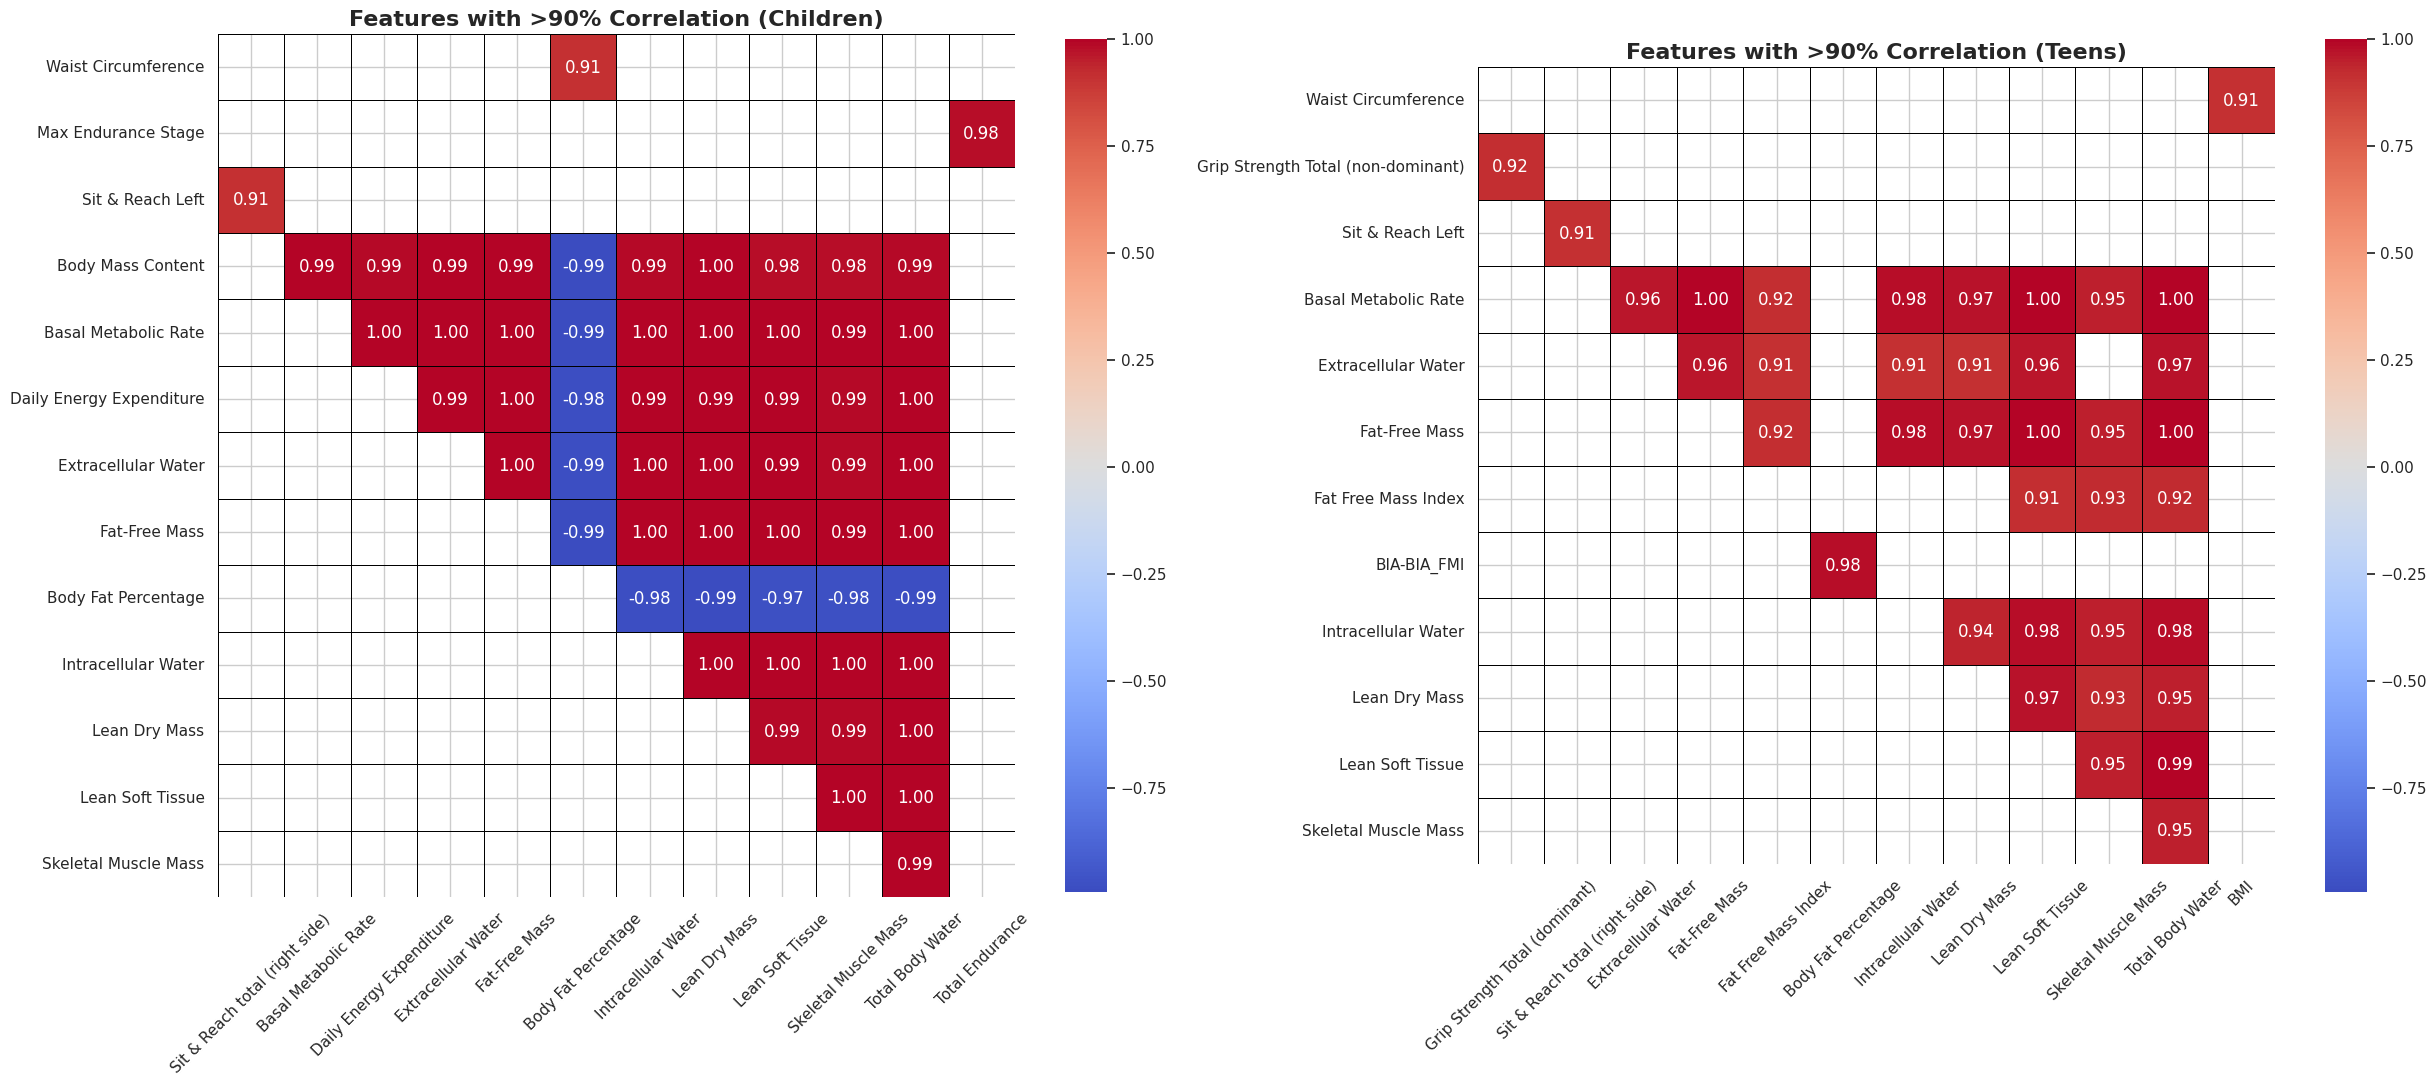

In [96]:


# Step 2: Function to Filter Correlations > 0.9

def filter_high_correlation(dataframe):

    correlation_matrix = dataframe.corr()

    high_corr_pairs = correlation_matrix.where(np.triu(np.abs(correlation_matrix) > 0.9, k=1))

    filtered_corr = high_corr_pairs.dropna(how='all').dropna(axis=1, how='all')

    return filtered_corr.rename(columns=name_mapping, index=name_mapping)



# Step 3: Filter High Correlation for Children and Teens

children_corr = filter_high_correlation(df_train_children)

teens_corr = filter_high_correlation(df_train_teens)



# Step 4: Calculate Unified Color Scale

vmin = min(children_corr.min().min(), teens_corr.min().min())  # Global minimum correlation

vmax = max(children_corr.max().max(), teens_corr.max().max())  # Global maximum correlation



# Step 5: Plot Heatmaps Side by Side

fig, axes = plt.subplots(1, 2, figsize=(25, 12))



# Heatmap for Children

sns.heatmap(

    children_corr,

    annot=True,

    cmap="coolwarm",

    vmin=vmin, vmax=vmax,  # Set unified color scale

    fmt=".2f",

    linewidths=0.5,

    linecolor="black",

    cbar_kws={"shrink": 0.8},

    ax=axes[0],

    square=True

)

axes[0].set_title("Features with >90% Correlation (Children)", fontsize=16, fontweight='bold')

axes[0].tick_params(axis='x', rotation=45)



# Heatmap for Teens

sns.heatmap(

    teens_corr,

    annot=True,

    cmap="coolwarm",

    vmin=vmin, vmax=vmax,  # Set unified color scale

    fmt=".2f",

    linewidths=0.5,

    linecolor="black",

    cbar_kws={"shrink": 0.8},

    ax=axes[1],

    square=True

)

axes[1].set_title("Features with >90% Correlation (Teens)", fontsize=16, fontweight='bold')

axes[1].tick_params(axis='x', rotation=45)



# Adjust Layout and Show Plot

plt.tight_layout()

# save as pdf

plt.savefig('correlation_heatmap.pdf',dpi = 600, format='pdf')

plt.show()


In [97]:
def cluster_and_drop_features(dataframe, exclude_columns=None, threshold=0.9):

    """

    Perform hierarchical clustering on highly correlated features and drop redundant features,

    while excluding specific columns from the process.

    """

    if exclude_columns is None:

        exclude_columns = []



    # Step 1: Exclude specified columns

    df_to_cluster = dataframe.drop(columns=exclude_columns)



    # Step 2: Compute the absolute correlation matrix

    corr_matrix = df_to_cluster.corr().abs()

    corr_matrix = corr_matrix.fillna(0)  # Handle NaNs or infinite values



    # Step 3: Perform hierarchical clustering

    linkage = sch.linkage(corr_matrix, method='ward')

    cluster = AgglomerativeClustering(

        n_clusters=None,

        distance_threshold=1-threshold,

        linkage='ward'

    )

    cluster.fit(corr_matrix)



    # Step 4: Assign features to clusters

    cluster_labels = cluster.labels_

    clusters = {}

    for feature, label in zip(corr_matrix.columns, cluster_labels):

        clusters.setdefault(label, []).append(feature)



    # Step 5: Select one representative feature per cluster

    selected_features = [sorted(features)[0] for features in clusters.values()]

    all_features = set(df_to_cluster.columns)

    features_to_drop = list(all_features - set(selected_features))



    # Step 6: Keep excluded columns intact

    final_features = selected_features + exclude_columns



    print("\nSelected Features:", selected_features)

    print("Dropped Features:", features_to_drop)



    return final_features ,features_to_drop



# Step 1: Perform Feature Selection on Training Data (Exclude SII)

exclude_columns = ["Severity Impairment Index (SII)"]

selected_children_features, dropped_children = cluster_and_drop_features(df_train_children, exclude_columns, threshold=0.9)

selected_teens_features, dropped_teens = cluster_and_drop_features(df_train_teens, exclude_columns, threshold=0.9)



# Step 2: Drop Redundant Features from Training Data (Keep SII)

df_train_children_reduced = df_train_children[selected_children_features]

df_train_teens_reduced = df_train_teens[selected_teens_features]



# Step 3: Apply the Same Feature Selection to Test Data (Exclude SII)

selected_children_features_no_sii = [col for col in selected_children_features if col != "Severity Impairment Index (SII)"]

selected_teens_features_no_sii = [col for col in selected_teens_features if col != "Severity Impairment Index (SII)"]



df_test_children_reduced = df_test_children[selected_children_features_no_sii]

df_test_teens_reduced = df_test_teens[selected_teens_features_no_sii]



# Step 4: Print Results

print("Original Training Children Shape:", df_train_children.shape)

print("Final Training Children Shape:", df_train_children_reduced.shape)

print("Original Test Children Shape:", df_test_children.shape)

print("Final Test Children Shape:", df_test_children_reduced.shape)



print("Original Training Teens Shape:", df_train_teens.shape)

print("Final Training Teens Shape:", df_train_teens_reduced.shape)

print("Original Test Teens Shape:", df_test_teens.shape)

print("Final Test Teens Shape:", df_test_teens_reduced.shape)



Selected Features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Max_Stage', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_T', 'Calculated-BMI', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Sex_1']
Dropped Features: ['Fitness_Endurance-Total', 'BIA-BIA_FFM', 'BIA-BIA_TBW', 'BIA-BIA_ECW']

Selected Features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Syst

# Drop Features with over 70% missing

In [98]:
def drop_high_missing_features(df, threshold=0.70):

    """

    Drops features with missing values greater than the specified threshold.



    Parameters:

        df: DataFrame

        threshold: float, proportion of missing values (default is 0.70)



    Returns:

        df_reduced: DataFrame after dropping features

        dropped_features: List of dropped feature names

    """

    # Calculate the percentage of missing values for each column

    missing_percentage = df.isnull().sum() / len(df)



    # Identify columns to drop

    features_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

    print(f"Features with >{threshold*100:.0f}% missing values:", features_to_drop)



    # Drop the features

    df_reduced = df.drop(columns=features_to_drop)



    return df_reduced, features_to_drop



# Apply to Training and Test Datasets

# For Children

df_train_children_reduced, dropped_children = drop_high_missing_features(df_train_children_reduced, threshold=0.70)

df_test_children_reduced = df_test_children_reduced.drop(columns=dropped_children)



# For Teens

df_train_teens_reduced, dropped_teens = drop_high_missing_features(df_train_teens_reduced, threshold=0.70)

df_test_teens_reduced = df_test_teens_reduced.drop(columns=dropped_teens)



# Print Results

print("\nDropped Features (Children):", dropped_children)

print("Reduced Children Dataset Shape (Train):", df_train_children_reduced.shape)

print("Reduced Children Dataset Shape (Test):", df_test_children_reduced.shape)



print("\nDropped Features (Teens):", dropped_teens)

print("Reduced Teens Dataset Shape (Train):", df_train_teens_reduced.shape)

print("Reduced Teens Dataset Shape (Test):", df_test_teens_reduced.shape)


Features with >70% missing values: ['Physical-Waist_Circumference', 'Fitness_Endurance-Max_Stage', 'FGC-FGC_GSND', 'FGC-FGC_GSD']
Features with >70% missing values: ['Physical-Waist_Circumference']

Dropped Features (Children): ['Physical-Waist_Circumference', 'Fitness_Endurance-Max_Stage', 'FGC-FGC_GSND', 'FGC-FGC_GSD']
Reduced Children Dataset Shape (Train): (3352, 35)
Reduced Children Dataset Shape (Test): (17, 34)

Dropped Features (Teens): ['Physical-Waist_Circumference']
Reduced Teens Dataset Shape (Train): (604, 37)
Reduced Teens Dataset Shape (Test): (3, 36)


# Remove Outliers

In [99]:
def remove_outliers(df, columns=None, iqr_multiplier=1.5, exclude_columns='Severity Impairment Index (SII)'):

    """

    Remove outliers from specified columns using IQR method.



    Parameters:

    - df: Input DataFrame

    - columns: List of columns to check for outliers (if None, process all numeric columns)

    - iqr_multiplier: Multiplier for IQR (default 1.5, standard for outlier detection)



    Returns:

    - DataFrame with outliers removed

    - Dictionary of removed outliers

    """

    # Create a copy of the dataframe

    df_cleaned = df.copy()



    # If no columns specified, select all numeric columns

    if columns is None:

        columns = df.select_dtypes(include=['float64', 'int64']).columns



    # Track removed outliers

    removed_outliers = {}

    # exclude columns

    columns = [col for col in columns if col != exclude_columns]



    for column in columns:

        # Skip if column doesn't exist or is not numeric

        if column not in df.columns or not pd.api.types.is_numeric_dtype(df[column]):

            continue



        # Calculate Q1, Q3, and IQR, ignoring NaNs

        Q1 = df[column].quantile(0.25)

        Q3 = df[column].quantile(0.75)

        IQR = Q3 - Q1



        # Define outlier bounds

        lower_bound = Q1 - (iqr_multiplier * IQR)

        upper_bound = Q3 + (iqr_multiplier * IQR)



        # Identify outliers (excluding NaNs)

        outliers = df[

            (df[column] < lower_bound) |

            (df[column] > upper_bound)

        ]



        # Remove outliers

        df_cleaned = df_cleaned[

            (df_cleaned[column] >= lower_bound) &

            (df_cleaned[column] <= upper_bound) |

            (df_cleaned[column].isna())

        ]



        # Store removed outliers

        if len(outliers) > 0:

            removed_outliers[column] = outliers



        # Print outlier information

        print(f"\nColumn: {column}")

        print(f"Outlier Bounds: [{lower_bound}, {upper_bound}]")

        print(f"Removed {len(outliers)} outliers")



    # Overall summary

    print("\nTotal Outliers Removed:")

    for col, outliers in removed_outliers.items():

        print(f"{col}: {len(outliers)} outliers")



    print(f"\nOriginal DataFrame Shape: {df.shape}")

    print(f"Cleaned DataFrame Shape: {df_cleaned.shape}")



    return df_cleaned, removed_outliers



# Apply to both datasets

df_train_children_reduced, _ = remove_outliers(df_train_children_reduced)

df_train_teens_reduced, _ = remove_outliers(df_train_teens_reduced)


Column: Basic_Demos-Age
Outlier Bounds: [1.0, 17.0]
Removed 0 outliers

Column: CGAS-CGAS_Score
Outlier Bounds: [37.5, 97.5]
Removed 11 outliers

Column: Physical-Diastolic_BP
Outlier Bounds: [40.0, 96.0]
Removed 100 outliers

Column: Physical-HeartRate
Outlier Bounds: [46.0, 118.0]
Removed 16 outliers

Column: Physical-Systolic_BP
Outlier Bounds: [80.5, 148.5]
Removed 140 outliers

Column: FGC-FGC_CU
Outlier Bounds: [-16.0, 32.0]
Removed 75 outliers

Column: FGC-FGC_PU
Outlier Bounds: [-12.0, 20.0]
Removed 60 outliers

Column: FGC-FGC_SRL
Outlier Bounds: [1.0, 17.0]
Removed 97 outliers

Column: FGC-FGC_SRR
Outlier Bounds: [1.0, 17.0]
Removed 88 outliers

Column: FGC-FGC_TL
Outlier Bounds: [-0.5, 19.5]
Removed 3 outliers

Column: BIA-BIA_BMC
Outlier Bounds: [-0.3771849999999999, 8.354415]
Removed 125 outliers

Column: BIA-BIA_BMR
Outlier Bounds: [650.2475000000002, 1558.7794999999999]
Removed 69 outliers

Column: BIA-BIA_DEE
Outlier Bounds: [745.5550000000002, 2936.835]
Removed 58 out

#Impute Missing Values for Features

In [100]:


def impute_missing_values(df_train, df_test, exclude_columns=None):

    """

    Imputes missing values in numerical and categorical columns.

    - Numerical: KNN Imputation

    - Categorical: Most Frequent Imputation (Mode)



    Parameters:

        df_train: Training DataFrame

        df_test: Testing DataFrame

        exclude_columns: List of columns to exclude from imputation



    Returns:

        df_train_imputed: Imputed Training DataFrame

        df_test_imputed: Imputed Testing DataFrame

    """

    if exclude_columns is None:

        exclude_columns = []



    # Drop excluded columns temporarily

    train_copy = df_train.drop(columns=exclude_columns, errors='ignore')

    test_copy = df_test.copy()



    # Separate numerical and categorical columns

    numerical_features = train_copy.select_dtypes(include=['float64', 'int64']).columns

    categorical_features = train_copy.select_dtypes(include=['object', 'category']).columns



    print("Numerical Features:", numerical_features.tolist())

    print("Categorical Features:", categorical_features.tolist())



    # Step 1: KNN Imputer for Numerical Features

    knn_imputer = KNNImputer(n_neighbors=5)

    train_copy[numerical_features] = knn_imputer.fit_transform(train_copy[numerical_features])

    test_copy[numerical_features] = knn_imputer.transform(test_copy[numerical_features])



    # Step 2: Simple Imputer (Mode) for Categorical Features

    mode_imputer = SimpleImputer(strategy='most_frequent')

    train_copy[categorical_features] = mode_imputer.fit_transform(train_copy[categorical_features])

    test_copy[categorical_features] = mode_imputer.transform(test_copy[categorical_features])



    # Step 3: Add back excluded columns

    for col in exclude_columns:

        train_copy[col] = df_train[col]



    return train_copy, test_copy



# Step 1: Apply Imputation on Children Dataset

exclude_columns = ["Severity Impairment Index (SII)"]  # Exclude SII from imputation

df_train_children_imputed, df_test_children_imputed = impute_missing_values(

    df_train_children_reduced, df_test_children_reduced, exclude_columns

)



# Step 2: Apply Imputation on Teens Dataset

df_train_teens_imputed, df_test_teens_imputed = impute_missing_values(

    df_train_teens_reduced, df_test_teens_reduced, exclude_columns

)



# Verify Results

print("\nImputed Children Dataset Shape (Train):", df_train_children_imputed.shape)

print("Imputed Children Dataset Shape (Test):", df_test_children_imputed.shape)



print("\nImputed Teens Dataset Shape (Train):", df_train_teens_imputed.shape)

print("Imputed Teens Dataset Shape (Test):", df_test_teens_imputed.shape)


Numerical Features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_T', 'Calculated-BMI', 'Basic_Demos-Sex_1']
Categorical Features: ['BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'PreInt_EduHx-computerinternet_hoursday']
Numerical Features: ['Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-

# Impute The Target

## Advanced Stratified Imputation



### Key Steps:

1. **Feature Selection**: Use the top 5 most correlated features with `SII`.

2. **Stratified Cross-Validation**: Perform 5-fold stratified sampling to handle class imbalance.

3. **Scaling**: Standardize features using `StandardScaler`.

4. **Model Training**: Train a `RandomForestClassifier` with `class_weight='balanced'`.

5. **Best Model Selection**: Choose the model with the highest validation accuracy.

6. **Imputation**: Predict and fill missing `SII` values using the best model.



### Benefits:

- Handles class imbalance effectively.  

- Uses top features for accurate predictions.  

- Ensures robust imputation with cross-validation.  



### Output:

Imputed missing `SII` values with distribution summary.

In [101]:


def advanced_stratified_imputation(df, target_column):

    """

    Advanced imputation strategy with:

    - Stratified sampling

    - Feature selection based on correlations

    - Cross-validation

    - Handling class imbalance

    """

    # Identify correlations and select top features

    correlations = df.corr()[target_column].abs().sort_values(ascending=False)

    top_correlated_features = correlations[1:6].index.tolist()



    # Prepare data

    known_data = df[df[target_column].notna()]

    unknown_data = df[df[target_column].isna()]



    # Feature preparation

    X = known_data[top_correlated_features]

    y = known_data[target_column]



    # Stratified Cross-Validation

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



    # Scalers and models for each fold

    scalers = []

    models = []

    fold_scores = []



    for train_index, val_index in skf.split(X, y):

        X_train, X_val = X.iloc[train_index], X.iloc[val_index]

        y_train, y_val = y.iloc[train_index], y.iloc[val_index]



        # Scale features

        scaler = StandardScaler()

        X_train_scaled = scaler.fit_transform(X_train)

        X_val_scaled = scaler.transform(X_val)

        scalers.append(scaler)



        # Model with class weights

        model = RandomForestClassifier(

            n_estimators=100,

            class_weight='balanced',

            random_state=42

        )

        model.fit(X_train_scaled, y_train)

        models.append(model)



        # Evaluate

        y_pred = model.predict(X_val_scaled)

        fold_score = accuracy_score(y_val, y_pred)

        fold_scores.append(fold_score)



        print(f"Fold Validation Accuracy: {fold_score:.4f}")



    # Detailed classification report for best model

    best_model_index = np.argmax(fold_scores)

    best_scaler = scalers[best_model_index]

    best_model = models[best_model_index]



    # Impute unknown data

    X_unknown = unknown_data[top_correlated_features]

    X_unknown_scaled = best_scaler.transform(X_unknown)



    imputed_values = best_model.predict(X_unknown_scaled)



    # Create imputed dataframe

    df_imputed = df.copy()

    df_imputed.loc[df[target_column].isna(), target_column] = imputed_values



    # Print imputation summary

    print("\nImputation Summary:")

    print(f"Total missing values: {len(imputed_values)}")

    print("Imputed Value Distribution:")

    print(pd.Series(imputed_values).value_counts(normalize=True))



    return df_imputed



# Apply to both datasets

df_train_children_imputed = advanced_stratified_imputation(

    df_train_children_imputed,

    "Severity Impairment Index (SII)"

)



df_train_teens_imputed = advanced_stratified_imputation(

    df_train_teens_imputed,

    "Severity Impairment Index (SII)"

)

Fold Validation Accuracy: 0.5952
Fold Validation Accuracy: 0.5170
Fold Validation Accuracy: 0.5238
Fold Validation Accuracy: 0.5529
Fold Validation Accuracy: 0.5563

Imputation Summary:
Total missing values: 1141
Imputed Value Distribution:
0.0    0.815074
1.0    0.144610
2.0    0.040316
Name: proportion, dtype: float64
Fold Validation Accuracy: 0.3654
Fold Validation Accuracy: 0.4231
Fold Validation Accuracy: 0.3462
Fold Validation Accuracy: 0.3333
Fold Validation Accuracy: 0.3725

Imputation Summary:
Total missing values: 229
Imputed Value Distribution:
1.0    0.401747
0.0    0.397380
2.0    0.196507
3.0    0.004367
Name: proportion, dtype: float64


# ML

In [102]:
# Custom Metric: Quadratic Weighted Kappa
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)
def optimize_model(X_train, y_train, X_val, y_val, model_name="xgboost"):
    def objective(params):
        # Ensure parameters are mapped correctly
        params['n_estimators'] = [50, 100, 200, 300, 500][params['n_estimators']]
        params['max_depth'] = [3, 5, 7, 9, 12][params['max_depth']]
        
        # Model selection
        if model_name == "xgboost":
            model = xgb.XGBClassifier(
                objective="multi:softmax",
                num_class=len(np.unique(y_train)),
                subsample=params.get('subsample', 1.0),
                colsample_bytree=params.get('colsample_bytree', 1.0),
                learning_rate=params['learning_rate'],
                n_estimators=params['n_estimators'],
                max_depth=params['max_depth'],
                use_label_encoder=False,
                n_jobs=-1
            )
        else:
            raise ValueError("Unsupported model")

        # Fit model with early stopping
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=30,
            verbose=False
        )

        # Predict and calculate QWK
        y_pred = model.predict(X_val)
        score = quadratic_weighted_kappa(y_val, y_pred)
        return {'loss': -score, 'status': STATUS_OK}

    # Search Space
    space = {
        'n_estimators': hp.choice('n_estimators', [0, 1, 2, 3, 4]),  # Indices
        'max_depth': hp.choice('max_depth', [0, 1, 2, 3, 4]),
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0)
    }

    # Hyperopt Trials
    trials = Trials()
    best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

    # Map indices back to values
    best_params['n_estimators'] = [50, 100, 200, 300, 500][best_params['n_estimators']]
    best_params['max_depth'] = [3, 5, 7, 9, 12][best_params['max_depth']]
    
    print("Best Parameters:", best_params)
    return best_params


In [103]:


# --- Model for Children ---

X_children = df_train_children_imputed.drop(columns=[ 'Severity Impairment Index (SII)'])

y_children = df_train_children_imputed['Severity Impairment Index (SII)']



X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_children, y_children, test_size=0.2, random_state=42)



# Scaling

scaler_c = StandardScaler()

X_train_c_scaled = scaler_c.fit_transform(X_train_c)

X_val_c_scaled = scaler_c.transform(X_val_c)



# Hyperparameter Tuning and Model Training

print("Optimizing Children Model...")

best_params_children = optimize_model(X_train_c_scaled, y_train_c, X_val_c_scaled, y_val_c, model_name="xgboost")

children_model = xgb.XGBClassifier(**best_params_children
)


children_model.fit(X_train_c_scaled, y_train_c)


Optimizing Children Model...
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 1/20 [00:00<00:11,  1.69trial/s, best loss: -0.29114299851558634]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 2/20 [00:01<00:17,  1.04trial/s, best loss: -0.29114299851558634]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▌        | 3/20 [00:02<00:13,  1.28trial/s, best loss: -0.29114299851558634]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 4/20 [00:03<00:12,  1.30trial/s, best loss: -0.3344443386344158] 

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 25%|██▌       | 5/20 [00:04<00:12,  1.21trial/s, best loss: -0.34031517176201664]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 6/20 [00:04<00:09,  1.47trial/s, best loss: -0.34031517176201664]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 7/20 [00:04<00:07,  1.85trial/s, best loss: -0.34031517176201664]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 40%|████      | 8/20 [00:05<00:07,  1.55trial/s, best loss: -0.3443915114768298] 

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▌     | 9/20 [00:08<00:16,  1.46s/trial, best loss: -0.3443915114768298]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 10/20 [00:11<00:18,  1.85s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▌    | 11/20 [00:11<00:12,  1.36s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 12/20 [00:12<00:08,  1.03s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 13/20 [00:12<00:05,  1.25trial/s, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 14/20 [00:13<00:04,  1.25trial/s, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 15/20 [00:14<00:05,  1.03s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 16/20 [00:15<00:03,  1.06trial/s, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 18/20 [00:19<00:02,  1.37s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/trial, best loss: -0.37026154654541943]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 20/20 [00:20<00:00,  1.03s/trial, best loss: -0.37026154654541943]
Best Parameters: {'colsample_bytree': 0.8470830176337278, 'learning_rate': 0.011750726338088237, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6811100861380538}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8470830176337278, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.011750726338088237,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [104]:


# --- Model for Teens ---

X_teens = df_train_teens_imputed.drop(columns=[ 'Severity Impairment Index (SII)'])

y_teens = df_train_teens_imputed['Severity Impairment Index (SII)']



X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X_teens, y_teens, test_size=0.2, random_state=42)



# Scaling

scaler_t = StandardScaler()

X_train_t_scaled = scaler_t.fit_transform(X_train_t)

X_val_t_scaled = scaler_t.transform(X_val_t)



# Hyperparameter Tuning and Model Training

print("Optimizing Teens Model...")

best_params_teens = optimize_model(X_train_t_scaled, y_train_t, X_val_t_scaled, y_val_t, model_name="xgboost")




teens_model = xgb.XGBClassifier(**best_params_teens
)
teens_model.fit(X_train_t_scaled, y_train_t)


Optimizing Teens Model...
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



  5%|▌         | 1/20 [00:00<00:04,  3.96trial/s, best loss: -0.44714459295261233]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 10%|█         | 2/20 [00:00<00:04,  3.86trial/s, best loss: -0.4808806488991888] 

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 15%|█▌        | 3/20 [00:00<00:04,  3.96trial/s, best loss: -0.48949320148331266]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 20%|██        | 4/20 [00:01<00:05,  2.79trial/s, best loss: -0.48949320148331266]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 30%|███       | 6/20 [00:02<00:04,  2.85trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 35%|███▌      | 7/20 [00:02<00:05,  2.24trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 45%|████▌     | 9/20 [00:03<00:03,  3.18trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 50%|█████     | 10/20 [00:03<00:04,  2.03trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 55%|█████▌    | 11/20 [00:04<00:04,  2.04trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 60%|██████    | 12/20 [00:04<00:03,  2.47trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 65%|██████▌   | 13/20 [00:05<00:03,  2.00trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 70%|███████   | 14/20 [00:05<00:02,  2.22trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 75%|███████▌  | 15/20 [00:06<00:02,  2.25trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 80%|████████  | 16/20 [00:07<00:02,  1.44trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 85%|████████▌ | 17/20 [00:07<00:01,  1.69trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 90%|█████████ | 18/20 [00:08<00:01,  1.89trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 95%|█████████▌| 19/20 [00:08<00:00,  1.68trial/s, best loss: -0.5596065796167543]

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



100%|██████████| 20/20 [00:09<00:00,  2.15trial/s, best loss: -0.5755455605530568]
Best Parameters: {'colsample_bytree': 0.8210991641814495, 'learning_rate': 0.0542363516402838, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9989840447237145}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8210991641814495, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0542363516402838,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [105]:
df_test_children

# add the id from df_test_children to df_test_children_imputed

df_test_children_imputed['id'] = df_test_children['id']

# SAME FOR TEENS

df_test_teens_imputed['id'] = df_test_teens['id']

In [106]:


# --- Predictions ---

# Scale Test Data

X_test_children_scaled = scaler_c.transform(df_test_children_imputed.drop(columns=['id']))

X_test_teens_scaled = scaler_t.transform(df_test_teens_imputed.drop(columns=['id']))

children_predictions = children_model.predict(X_test_children_scaled)

teens_predictions = teens_model.predict(X_test_teens_scaled)



# Combine Predictions

children_results = pd.DataFrame({'id': df_test_children_imputed['id'], 'sii': children_predictions})

teens_results = pd.DataFrame({'id': df_test_teens['id'], 'sii': teens_predictions})



submission = pd.concat([children_results, teens_results], axis=0)

submission.to_csv('submission.csv', index=False)



print("Submission file created successfully!")


Submission file created successfully!


# Hypothesis Testing

In [107]:
# import scipy.stats as stats



# # Data preparation: Select relevant columns and drop missing values

# relevant_data = df_train_csv[['sii', 'PreInt_EduHx-computerinternet_hoursday', 'Physical-BMI']].dropna()



# # Extract variables for hypothesis testing

# ssi = relevant_data['sii']  # Target variable

# internet_hours = relevant_data['PreInt_EduHx-computerinternet_hoursday']  # Predictor 1

# bmi = relevant_data['Physical-BMI']  # Predictor 2



# # Hypothesis 1: Correlation between SSI and Internet Hours

# corr_internet, p_internet = stats.pearsonr(ssi, internet_hours)



# # Hypothesis 2: Correlation between SSI and BMI

# corr_bmi, p_bmi = stats.pearsonr(ssi, bmi)



# # Results summary

# results = {

#     "Hypothesis": ["SSI vs Internet Hours", "SSI vs BMI"],

#     "Correlation Coefficient": [corr_internet, corr_bmi],

#     "P-value": [p_internet, p_bmi],

# }

# results_df = pd.DataFrame(results)



# results_df